# Data Understanding #

## * Các Biến dữ liệu

Đánh giá Khu vực:
- REGION_RATING_CLIENT : Đánh giá của tổ chức về khu vực thường trú của khách hàng (1,2,3) (1: Tốt nhất, 3: Xấu nhất).
- REGION_RATING_CLIENT_W_CITY : Đánh giá của tổ chức về khu vực thường trú, có tính đến thành phố (1,2,3) (1: Tốt nhất, 3: Xấu nhất).

Địa lý :
- REG_REGION_NOT_LIVE_REGION : Cờ cho biết địa chỉ thường trú không khớp với địa chỉ liên hệ (cấp vùng/tỉnh). (1=Khác, 0=Giống)
- REG_REGION_NOT_WORK_REGION : Cờ cho biết địa chỉ thường trú không khớp với địa chỉ làm việc (cấp vùng/tỉnh). (1=Khác, 0=Giống)
- LIVE_REGION_NOT_WORK_REGION : Cờ cho biết địa chỉ liên hệ không khớp với địa chỉ làm việc (cấp vùng/tỉnh). (1=Khác, 0=Giống)
- REG_CITY_NOT_LIVE_CITY : Cờ cho biết địa chỉ thường trú không khớp với địa chỉ liên hệ (cấp thành phố). (1=Khác, 0=Giống)
- REG_CITY_NOT_WORK_CITY : Cờ cho biết địa chỉ thường trú không khớp với địa chỉ làm việc (cấp thành phố). (1=Khác, 0=Giống)
- LIVE_CITY_NOT_WORK_CITY : Cờ cho biết địa chỉ liên hệ không khớp với địa chỉ làm việc (cấp thành phố). (1=Khác, 0=Giống)

(==> Khách hàng thay đổi địa chỉ nhiều → rủi ro cao hơn (tính ổn định thấp).)

Nguồn ngoại vi:
- EXT_SOURCE_1/2/3 : Điểm số chuẩn hóa từ Nguồn dữ liệu bên ngoài 1/2/3 (Thường là điểm tín dụng từ các tổ chức khác).

Vòng tròn xã hội:
- OBS_30_CNT_SOCIAL_CIRCLE / OBS_60_CNT_SOCIAL_CIRCLE : Số lượng quan sát trong vòng tròn xã hội của khách hàng có khả năng mắc nợ quá hạn 30/60 ngày (DPD).
- DEF_30_CNT_SOCIAL_CIRCLE / DEF_60_CNT_SOCIAL_CIRCLE : Số lượng quan sát trong vòng tròn xã hội của khách hàng đã thực sự mắc nợ quá hạn 30/60 ngày (DPD).

( Các biến này đo lường mức độ rủi ro tín dụng của những người xung quanh khách hàng (ví dụ: bạn bè, người cùng địa chỉ) được tổ chức cho vay theo dõi. Đây là một yếu tố quan trọng trong một số mô hình chấm điểm tín dụng, vì hành vi tài chính của những người xung quanh có thể gián tiếp phản ánh môi trường tài chính và rủi ro của người vay.)

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr, f_oneway
from sklearn.metrics import mutual_info_score
from typing import Optional, Union, List, Dict, Tuple
import warnings
from processing.function import *
import importlib
import processing.function

importlib.reload(processing.function)
warnings.filterwarnings('ignore')

In [236]:
df = pd.read_csv("raw_data/train.csv")

In [237]:
# Chọn một số cột để phân tích
feature_list = [
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'
]
df_list = df[feature_list].copy()

In [238]:
# Phân loại cột số và cột danh mục
num_cols = df_list.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df_list.select_dtypes(include=["object"]).columns

print("Cột số:", len(num_cols), ":", num_cols)
print("Cột danh mục:", len(cat_cols), ":", cat_cols)

Cột số: 15 : Index(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')
Cột danh mục: 0 : Index([], dtype='object')


## * Biến liên tục

#### Univariate Analysis

|Tên biến| Giải thích tên biến | Ý nghĩa trong Credit Fault Context|
|--- | ---| --- |
|EXT_SOURCE_1/2/3| External Source Scores 1/2/3 (Điểm từ nguồn dữ liệu bên ngoài 1/2/3), được chuẩn hóa trong khoảng 0 → 1|Các điểm số này thường là chỉ số tín dụng (credit scores) hoặc các chỉ số rủi ro đã được tính toán bởi các tổ chức hoặc cơ quan bên ngoài|

==> Ý nghĩa: Đây là một trong những biến dự đoán quan trọng nhất. Chúng thường mang tính phi tuyến và tương quan ngược với target
- Điểm càng cao $\rightarrow$ Rủi ro tín dụng (Credit Fault/Default) càng thấp (khả năng khách hàng không trả nợ thấp). 
- Điểm càng thấp $\rightarrow$ Rủi ro tín dụng càng cao (khả năng không trả nợ cao).  


In [239]:
var_cont = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

In [240]:

# 1. Descriptive statistics
print(df[var_cont].describe())

# 2. Missing values
missing_info = pd.DataFrame({
    'Số lượng thiếu': df[var_cont].isnull().sum(),
    'Tỷ lệ thiếu (%)': df[var_cont].isnull().sum() / len(df) * 100
})

print(missing_info)
# 3. Top/bottom values
for col in var_cont:
    print(f"\nTop 5 values of {col}:")
    print(df[col].sort_values(ascending=False).head(5))
    
    print(f"\nBottom 5 values of {col}:")
    print(df[col].sort_values().head(5))

# 4. IQR info
for col in var_cont:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()

    print(f"\n{col} - IQR OUTLIER INFO")
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower bound: {lower}, Upper bound: {upper}")
    print(f"Number of outliers: {outliers}")


       EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3
count  93829.000000  2.147830e+05  172510.000000
mean       0.501568  5.140282e-01       0.510706
std        0.211350  1.913368e-01       0.194647
min        0.014568  8.173617e-08       0.000527
25%        0.332958  3.914698e-01       0.370650
50%        0.505499  5.656821e-01       0.535276
75%        0.674828  6.637635e-01       0.667458
max        0.951624  8.549997e-01       0.896010
              Số lượng thiếu  Tỷ lệ thiếu (%)
EXT_SOURCE_1          121429        56.410912
EXT_SOURCE_2             475         0.220665
EXT_SOURCE_3           42748        19.858960

Top 5 values of EXT_SOURCE_1:
177896    0.951624
43847     0.946098
46557     0.945741
91480     0.944420
29685     0.943982
Name: EXT_SOURCE_1, dtype: float64

Bottom 5 values of EXT_SOURCE_1:
119314    0.014568
30441     0.015600
65809     0.017177
7898      0.017394
168215    0.017756
Name: EXT_SOURCE_1, dtype: float64

Top 5 values of EXT_SOURCE_2:
36222     0.855
133

##### Biểu đồ

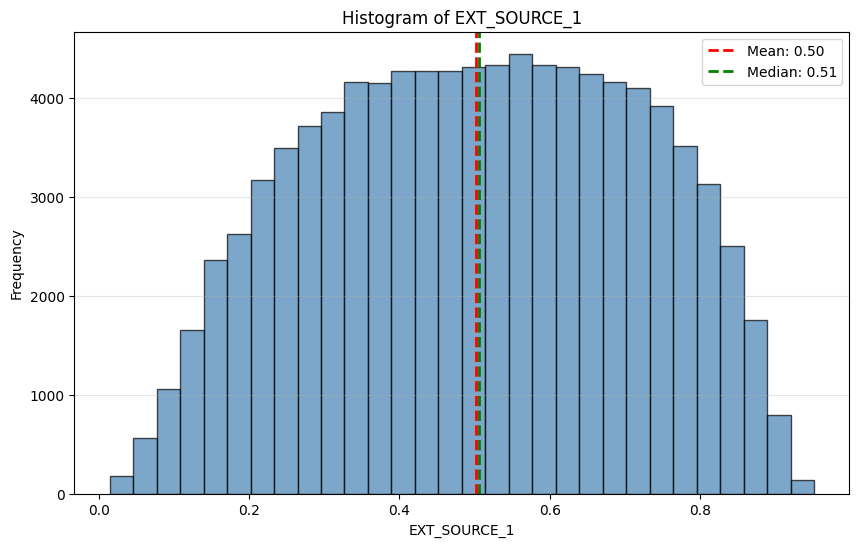

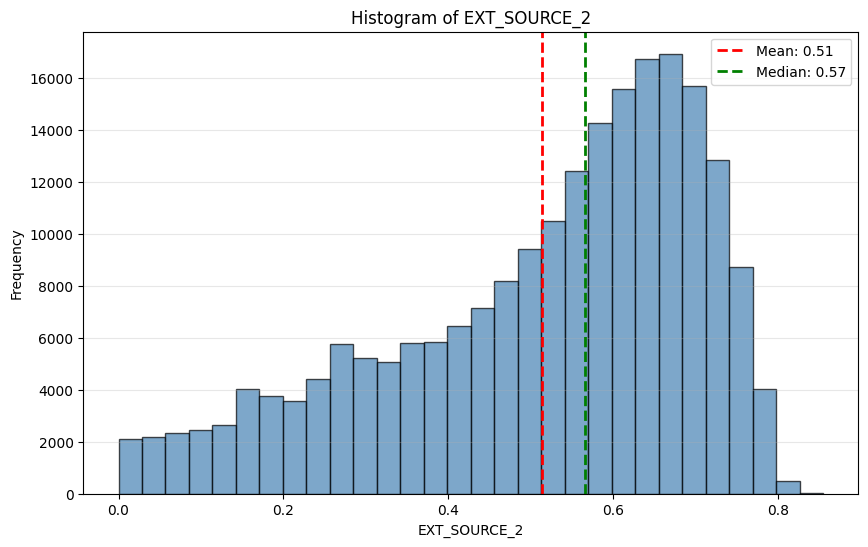

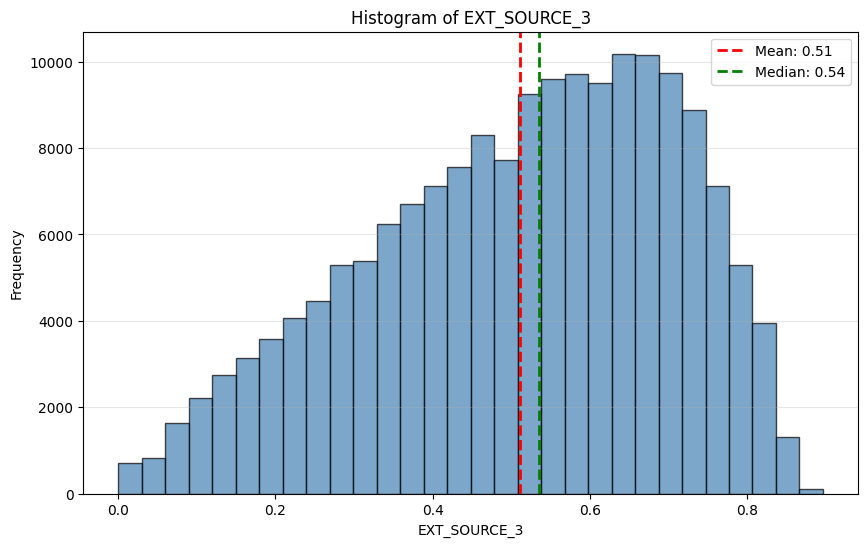

In [241]:
from processing.function import plot_nominal_topk_barchart

# Vẽ histogram cho từng biến liên tục  
bins = 30 
for col in var_cont:
    plot_continuous_histogram(df[col], bins=bins, title=f'Histogram of {col}')
      

##### Đánh giá: 
 1. EXT_SOURCE_1 – Phân phối gần như chuẩn, khá cân bằng

- Phân phối có dạng bell-shaped, khá đối xứng quanh trung tâm.

- Mean ≈ 0.50, median ≈ 0.51 → mean và median gần bằng nhau → dữ liệu không bị skew, khá cân bằng.

- Không có nhiều giá trị cực trị ở hai đầu (0 và 1), tập trung chủ yếu trong khoảng 0.2 – 0.8.

==> EXT_SOURCE_1 là biến “ổn định” và sạch, không bị lệch phân phối. Điều này cho thấy hồ sơ khách hàng trong tập dữ liệu có mức rủi ro trung bình khá đồng đều. Đây là một biến có chất lượng tốt để đưa vào mô hình.

 2. EXT_SOURCE_2 – Phân phối lệch phải mạnh (right-skewed) 

- Dữ liệu tập trung nhiều ở mức cao (0.55 – 0.75).

- Median (0.57) > Mean (0.51) → phân phối lệch phải.

- Ít khách hàng có điểm rất thấp (dưới 0.2), trong khi số lượng khách hàng có điểm rủi ro thấp (điểm cao) lại nhiều hơn.

==> Khách hàng trong dataset có xu hướng nhận được điểm đánh giá rủi ro bên ngoài khá tốt, cao hơn mức trung bình. Điều này cho thấy nhóm khách hàng “ít rủi ro” chiếm ưu thế.
EXT_SOURCE_2 có thể là biến phân tách tốt giữa người trả nợ đúng hạn và người vỡ nợ vì nó không cân bằng hoàn toàn như EXT_SOURCE_1.

3. EXT_SOURCE_3 – Lệch phải nhẹ, phân phối tương đối đồng đều

- Dữ liệu trải đều trong khoảng 0.2 – 0.8, nhưng tập trung nhiều hơn ở 0.55 – 0.70.

- Mean ≈ 0.51, Median ≈ 0.54 → lệch phải nhẹ.

- Không quá lệch như EXT_SOURCE_2 nhưng cũng không cân bằng như EXT_SOURCE_1.

==> EXT_SOURCE_3 cho thấy xu hướng tương tự EXT_SOURCE_2 nhưng nhẹ hơn. Khách hàng đa phần có điểm đánh giá rủi ro tương đối tốt. Sự lệch nhẹ cho thấy biến này cũng có khả năng hỗ trợ phân biệt nhóm rủi ro cao – thấp trong mô hình dự đoán.


##### Metrics

In [242]:
# Check Mean, Median, Skewness, Kurtosis cho các biến continuous
results = []

for col in var_cont:
    metrics = calculate_continuous_metrics(df[col])
    results.append(metrics)

metrics_df = pd.concat(results, ignore_index=True)
metrics_df

,Feature,Count,Missing,Mean,Median,Std,Min,Max,Skewness,Kurtosis
0,EXT_SOURCE_1,93829,121429,0.501568,0.505499,0.211350,1.456813e-02,0.951624,-0.067376,-0.970725
1,EXT_SOURCE_2,214783,475,0.514028,0.565682,0.191337,8.173617e-08,0.855000,-0.788995,-0.281104
2,EXT_SOURCE_3,172510,42748,0.510706,0.535276,0.194647,5.272652e-04,0.896010,-0.412465,-0.653477


#### Đánh giá

1. EXT_SOURCE_1: 
- Missing values lớn (121,429)( chiếm 56,41% trong cột), chiếm tỷ lệ đáng kể so với Count các quan sát có sẵn (93,829). 

- Phân phối:

Mean ($0.501568$) $\approx$ Median ($0.505499$) -> phân phối gần như đối xứng.

Skewness $(-0.067376)$ rất gần $0$ -> khẳng định tính đối xứng.

Kurtosis $(-0.970725)$ là âm -> phân phối platykurtic( phẳng hơn) so với phân phối chuẩn.

Std ($0.211350$) là cao nhất trong ba đặc trưng -> biến động lớn nhất.

2. EXT_SOURCE_2
- Mising values rất ít (chỉ 475)( chiếm 0,22%), và có số lượng Count lớn nhất (214,783). 

- Phân phối:
Median ($0.565682$) lớn hơn đáng kể so với Mean ($0.514028$) -> phân phối lệch trái 

Skewness ($-0.788995$) là âm và có giá trị lớn nhất (tuyệt đối), xác nhận tính lệch trái mạnh nhất trong ba đặc trưng.

Kurtosis ($-0.281104$) là âm -> phân phối phẳng.

Min ($8.173617e-08$) là giá trị nhỏ nhất, gần như bằng 0.

3. EXT_SOURCE_3
- Missing values đáng kể (42,748)( khoảng 19,85%), ít hơn EXT_SOURCE_1 nhưng vẫn cần được xử lý.

- Phân phối:
Mean ($0.510706$) và Median ($0.535276$) gần nhau, nhưng Median cao hơn, cho thấy phân phối có xu hướng lệch trái nhẹ.

Skewness ($-0.412465$) là âm và ở mức trung bình, xác nhận tính lệch trái vừa phải.

Kurtosis ($-0.653477$) là âm -> phân phối phẳng.

Std ($0.194647$) nằm giữa hai đặc trưng còn lại.


#### Bivariate Analysis vs Target

Biểu đồ

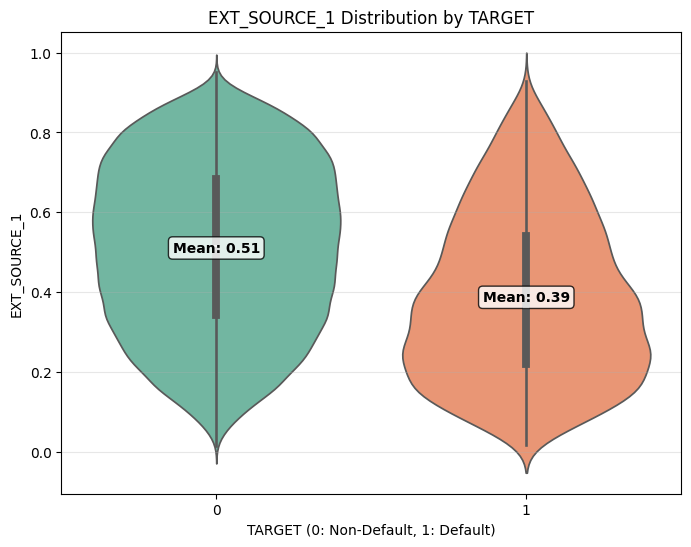

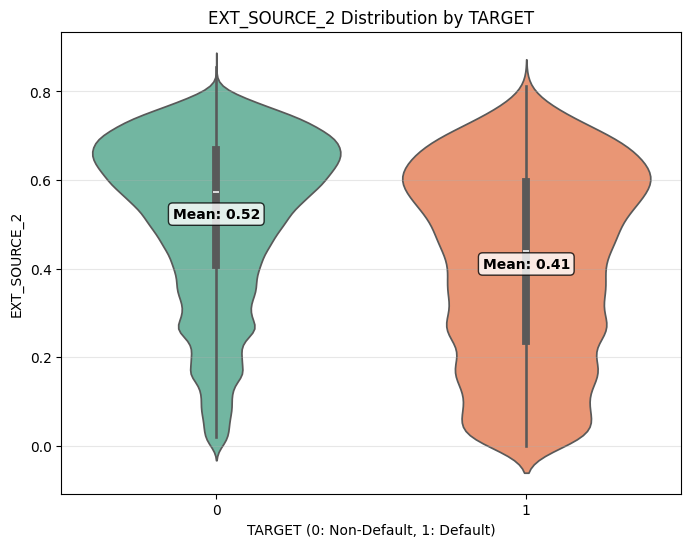

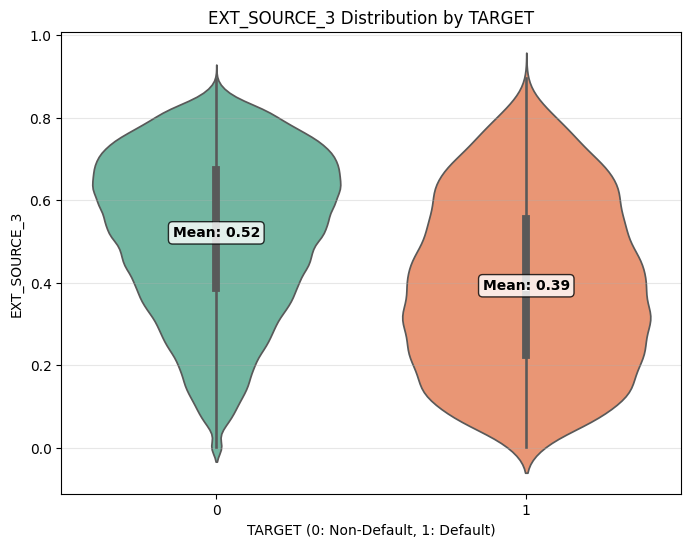

In [243]:
# Vẽ violin plot cho các biến liên tục so với TARGET
for col in var_cont:
    plot_continuous_violin_vs_target(df, feature=col, target='TARGET', 
                                    title=f'{col} Distribution by TARGET', figsize=(8,6))

#### Đánh giá
Mean của nhóm TARGET=0 (Không Mặc định) luôn cao hơn đáng kể so với nhóm TARGET=1 (Mặc định).==> Điều này cho thấy rằng khách hàng có điểm EXT_SOURCE cao hơn thì ít có khả năng bị mặc định khoản vay. Giá trị EXT_SOURCE_x càng cao, khả năng khách hàng thuộc TARGET=0 càng lớn. Ngược lại, điểm EXT_SOURCE_x thấp là dấu hiệu mạnh của TARGET=1.

1. EXT_SOURCE_1    
Sự lệch mean trung bình mạnh ($0.12$). Trong đó, Nhóm TARGET=1 có phân phối thấp và rộng hơn đáng kể ở vùng giá trị thấp, cho thấy một số lượng lớn khách hàng rủi ro tập trung ở khu vực này.

2. EXT_SOURCE_2     
Sự lệch mean tốt ($0.11$), nhưng kém hơn EXT_SOURCE_1 và EXT_SOURCE_3. Mặc dù khoảng cách nhỏ nhất, đặc trưng này là đáng tin cậy nhất về mặt số lượng (chỉ có $\sim 475$ missing). Trong đó, phân phối cả haicó xu hướng lệch trái nhẹ.

3. EXT_SOURCE_3    
Sự lệch mean rõ rệt nhất ($0.13$), có thể trở thành đặc trưng tốt nhất. Trong đó, phân phối TARGET=0 chủ yếu tập trung (hình dạng thắt eo/kim cương) ở vùng giá trị cao ($\approx 0.5$ đến $0.7$), cho thấy hầu hết khách hàng tốt có điểm nằm trong phạm vi này. Phân phối TARGET=1 trải rộng hơn và có một lượng đáng kể khách hàng mặc định có điểm EXT_SOURCE_3 dưới 0.2.

Metrics

In [244]:
from scipy.stats import pointbiserialr, f_oneway

# Chạy cho tất cả continuous features
results = []
for col in var_cont:
    metrics = calculate_target_relationship_continuous(df, feature=col, target='TARGET')
    results.append(metrics)
relationship_df = pd.concat(results, ignore_index=True)
relationship_df
   

,Feature,Point_Biserial_Correlation,Point_Biserial_P_Value,ANOVA_F_Statistic,ANOVA_P_Value
0,EXT_SOURCE_1,-0.153410,0.0,2261.411181,0.0
1,EXT_SOURCE_2,-0.160295,0.0,5664.247615,0.0
2,EXT_SOURCE_3,-0.176641,0.0,5555.962189,0.0


#### Đánh giá
- P_Value = 0.0 (Đối với cả Point Biserial và ANOVA) -> Tất cả ba biến EXT_SOURCE 1/2/3 đều có mối quan hệ có ý nghĩa thống kê với biến Target .

- Hệ số Tương quan đều mang giá trị âm, trong đó EXT_SOURCE_3 có tương quan âm mạnh nhất  $|-0.176641|$. -> Có một mối tương quan nghịch (âm) giữa các biến ngoại sinh (EXT_SOURCE) và biến mục tiêu.

- Giá trị F Statistic rất lớn -> Các biến EXT_SOURCE có khả năng phân biệt giá trị trung bình của biến mục tiêu rất tốt giữa các nhóm (hoặc các giá trị) khác nhau của biến EXT_SOURCE.

## * Biến rời rạc

#### Univariate Analysis

 - Biến Ordinal:  

|Tên biến| Giải thích tên biến |Giá trị| Ý nghĩa trong Credit Fault Context|
|--- | ---| --- |--- |
|REGION_RATING_CLIENT| Đánh giá khu vực thường trú của khách hàng.Phản ánh sự phát triển kinh tế, cơ sở hạ tầng, và tỷ lệ vỡ nợ trung bình của khu vực đó.|1,2,3|Rating 1 (Tốt nhất) $\rightarrow$ Khách hàng ở khu vực ổn định, rủi ro vỡ nợ thấp hơn. Rating càng cao (2 hoặc 3), rủi ro càng tăng.|
|REGION_RATING_CLIENT_W_CITY| Đánh giá khu vực thường trú của khách hàng nhưng Đánh giá chi tiết hơn, có tính đến cấp thành phố hoặc khu vực đô thị..|1,2,3|Tương tự như trên, nhưng chi tiết hơn ở cấp thành phố. Sự khác biệt giữa hai biến này có thể chỉ ra rằng mặc dù vùng/tỉnh được đánh giá cao, nhưng thành phố cụ thể lại mang rủi ro khác.|

- Biến Binary/Flag:   

|Tên biến| Giải thích tên biến |Giá trị| Ý nghĩa trong Credit Fault Context|
|--- | ---| --- |--- |
|REG_REGION_NOT_LIVE_REGION| Cờ: Địa chỉ thường trú KHÔNG khớp với địa chỉ liên hệ (cấp vùng/tỉnh).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Cho thấy khách hàng có sự thay đổi về vùng/tỉnh nơi họ sinh sống chính thức và nơi họ liên hệ, ngụ ý tính ổn định thấp hoặc thông tin không nhất quán.|
|REG_REGION_NOT_WORK_REGION| Cờ: Địa chỉ thường trú KHÔNG khớp với địa chỉ làm việc (cấp vùng/tỉnh).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Thường trú và nơi làm việc cách xa nhau về mặt hành chính/địa lý, có thể liên quan đến sự ổn định công việc/cuộc sống thấp.|
LIVE_REGION_NOT_WORK_REGION|Cờ: Địa chỉ liên hệ KHÔNG khớp với địa chỉ làm việc (cấp vùng/tỉnh).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Giống như trên, cho thấy sự không nhất quán hoặc sự phức tạp trong cuộc sống/công việc, liên quan đến tính ổn định thấp.|
REG_CITY_NOT_LIVE_CITY| Cờ: Địa chỉ thường trú KHÔNG khớp với địa chỉ liên hệ (cấp thành phố).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Thay đổi/không nhất quán ở cấp độ thành phố, thường gặp hơn nhưng vẫn là dấu hiệu của tính ổn định thấp.|
REG_CITY_NOT_WORK_CITY| Cờ: Địa chỉ thường trú KHÔNG khớp với địa chỉ làm việc (cấp thành phố).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Thường trú và làm việc ở các thành phố khác nhau, có thể gây khó khăn trong việc xác minh thông tin và liên quan đến rủi ro cao hơn.|
LIVE_CITY_NOT_WORK_CITY| Cờ: Địa chỉ liên hệ KHÔNG khớp với địa chỉ làm việc (cấp thành phố).|1=Khác, 0=Giống|Giá trị 1 $\rightarrow$ Rủi ro cao. Không nhất quán ở cấp độ thành phố, ngụ ý tính ổn định thấp.|

- Biến Count Variables:   

|Tên biến| Giải thích tên biến | Ý nghĩa trong Credit Fault Context|
|---|---|---|
|OBS_30_CNT_SOCIAL_CIRCLE| Số lượng người trong vòng tròn xã hội của KH có khả năng mắc nợ quá hạn 30 ngày (DPD).|Số lượng càng lớn $\rightarrow$ Rủi ro cao. Vòng tròn xã hội có vấn đề tài chính là một yếu tố rủi ro lây lan (financial contagion risk).|
|OBS_60_CNT_SOCIAL_CIRCLE| Số lượng người trong vòng tròn xã hội của KH có khả năng mắc nợ quá hạn 60 ngày (DPD).|Số lượng càng lớn $\rightarrow$ Rủi ro cao. Tương tự như trên, nhưng liên quan đến nợ quá hạn dài hơn.|
|DEF_30_CNT_SOCIAL_CIRCLE| Số lượng người trong vòng tròn xã hội của KH đã thực sự mắc nợ quá hạn 30 ngày (DPD).|Số lượng càng lớn $\rightarrow$ Rủi ro RẤT cao. Đây là chỉ báo rủi ro trực tiếp và mạnh mẽ, vì nó dựa trên sự kiện vỡ nợ đã xảy ra.|
|DEF_60_CNT_SOCIAL_CIRCLE| Số lượng người trong vòng tròn xã hội của KH đã thực sự mắc nợ quá hạn 60 ngày (DPD).|Số lượng càng lớn $\rightarrow$ Rủi ro RẤT cao. Chỉ báo rủi ro trực tiếp liên quan đến nợ quá hạn nghiêm trọng (60 ngày).|

In [245]:
var_discrete = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

In [246]:
# 1. Descriptive statistics
print(df[var_discrete].describe())

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count         215258.000000                215258.000000   
mean               2.052885                     2.031883   
std                0.509232                     0.502752   
min                1.000000                     1.000000   
25%                2.000000                     2.000000   
50%                2.000000                     2.000000   
75%                2.000000                     2.000000   
max                3.000000                     3.000000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count               215258.000000                215258.00000   
mean                     0.015200                     0.05079   
std                      0.122349                     0.21957   
min                      0.000000                     0.00000   
25%                      0.000000                     0.00000   
50%                      0.000000                     0.00000   
75% 

In [247]:
# 2. Missing values và phần trăm missing
missing_info = pd.DataFrame({
    'Số lượng thiếu': df[var_discrete].isnull().sum(),
    'Tỷ lệ thiếu (%)': df[var_discrete].isnull().sum() / len(df_list) * 100
})

print(missing_info)

                             Số lượng thiếu  Tỷ lệ thiếu (%)
REGION_RATING_CLIENT                      0         0.000000
REGION_RATING_CLIENT_W_CITY               0         0.000000
REG_REGION_NOT_LIVE_REGION                0         0.000000
REG_REGION_NOT_WORK_REGION                0         0.000000
LIVE_REGION_NOT_WORK_REGION               0         0.000000
REG_CITY_NOT_LIVE_CITY                    0         0.000000
REG_CITY_NOT_WORK_CITY                    0         0.000000
LIVE_CITY_NOT_WORK_CITY                   0         0.000000
OBS_30_CNT_SOCIAL_CIRCLE                712         0.330766
DEF_30_CNT_SOCIAL_CIRCLE                712         0.330766
OBS_60_CNT_SOCIAL_CIRCLE                712         0.330766
DEF_60_CNT_SOCIAL_CIRCLE                712         0.330766


In [248]:
# 3. IQR info
for col in var_discrete:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()

    total_count = len(df)
    outliers_percent = (outliers / total_count) * 100

    print(f"\n{col} - IQR OUTLIER INFO")
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Lower bound: {lower}, Upper bound: {upper}")
    print(f"Number of outliers: {outliers} ({outliers_percent:.2f}%)")


REGION_RATING_CLIENT - IQR OUTLIER INFO
Q1: 2.0, Q3: 2.0, IQR: 0.0
Lower bound: 2.0, Upper bound: 2.0
Number of outliers: 56422 (26.21%)

REGION_RATING_CLIENT_W_CITY - IQR OUTLIER INFO
Q1: 2.0, Q3: 2.0, IQR: 0.0
Lower bound: 2.0, Upper bound: 2.0
Number of outliers: 54627 (25.38%)

REG_REGION_NOT_LIVE_REGION - IQR OUTLIER INFO
Q1: 0.0, Q3: 0.0, IQR: 0.0
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 3272 (1.52%)

REG_REGION_NOT_WORK_REGION - IQR OUTLIER INFO
Q1: 0.0, Q3: 0.0, IQR: 0.0
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 10933 (5.08%)

LIVE_REGION_NOT_WORK_REGION - IQR OUTLIER INFO
Q1: 0.0, Q3: 0.0, IQR: 0.0
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 8700 (4.04%)

REG_CITY_NOT_LIVE_CITY - IQR OUTLIER INFO
Q1: 0.0, Q3: 0.0, IQR: 0.0
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 16817 (7.81%)

REG_CITY_NOT_WORK_CITY - IQR OUTLIER INFO
Q1: 0.0, Q3: 0.0, IQR: 0.0
Lower bound: 0.0, Upper bound: 0.0
Number of outliers: 49636 (23.06%)

LIVE_CITY

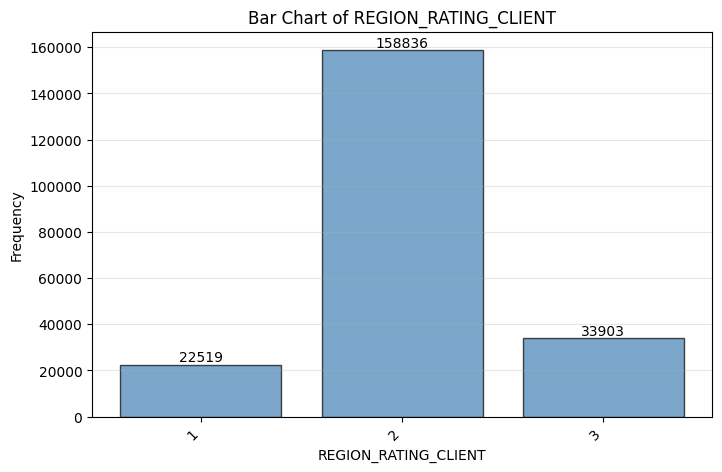

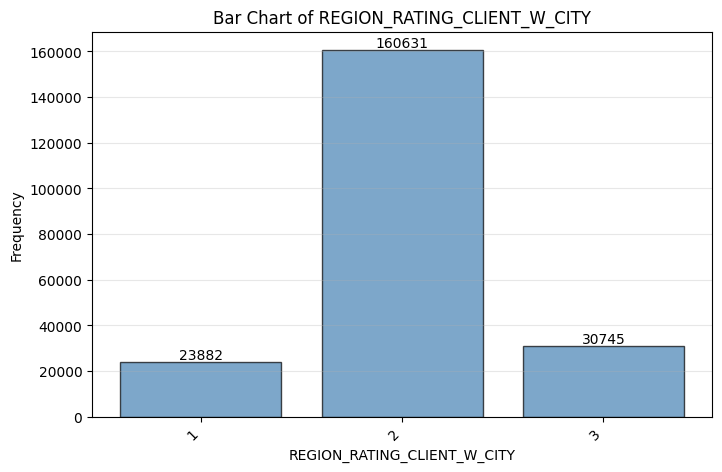

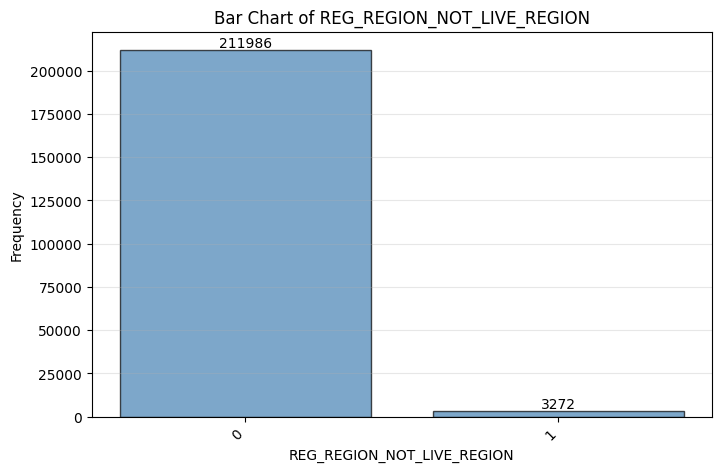

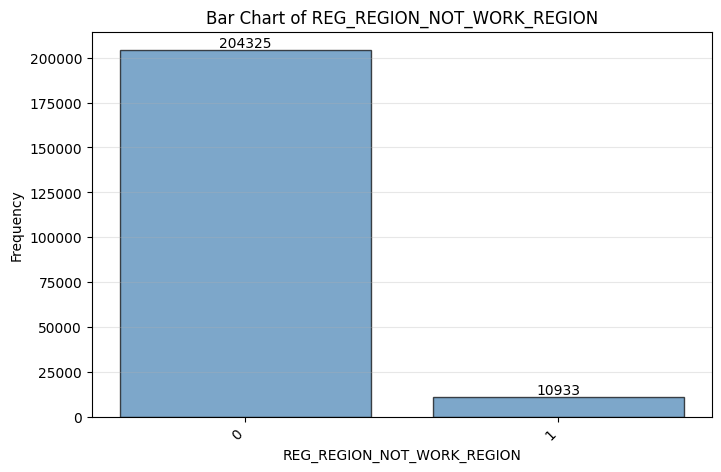

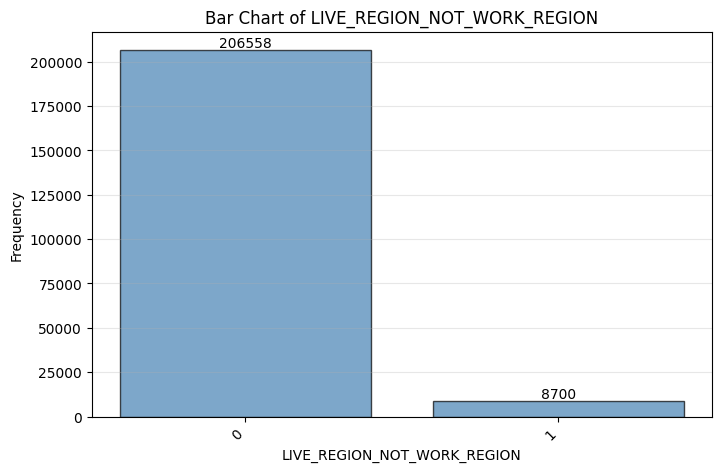

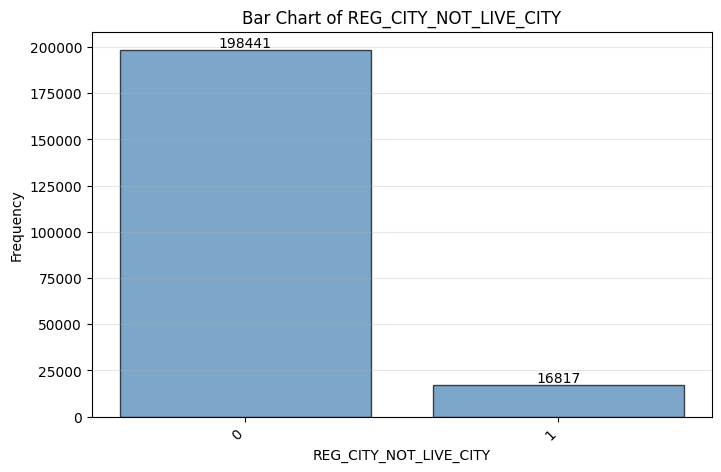

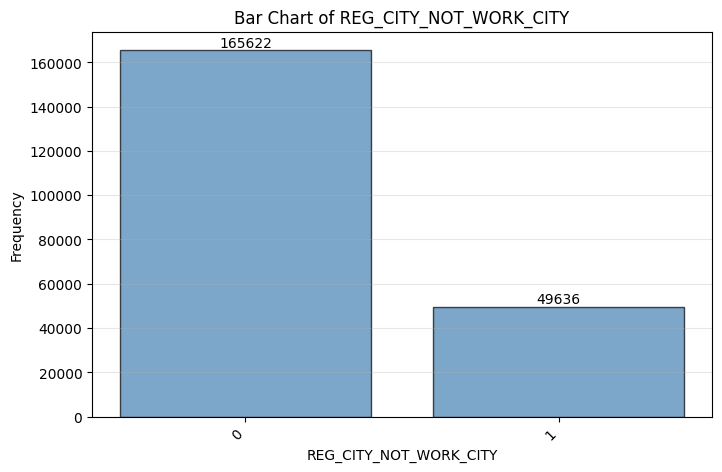

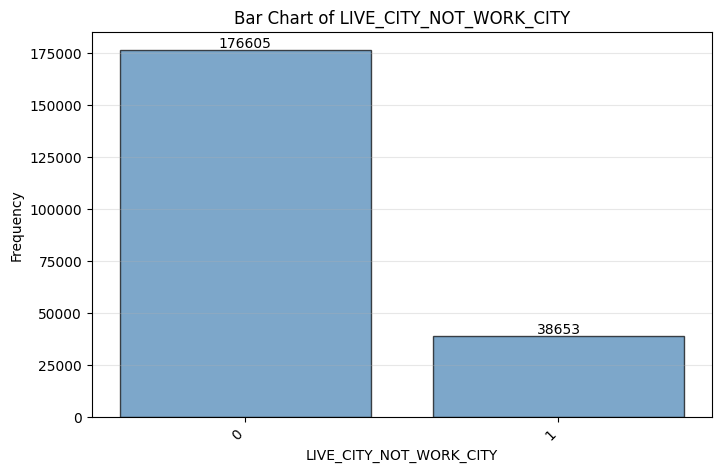

In [249]:
cols_live = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
        'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
        'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

# Vẽ bar chart cho các biến rời rạc ít giá trị
for col in cols_live:
    plot_discrete_barchart(df[col], title=f'Bar Chart of {col}', figsize=(8,5))
    

#### Đánh giá

- REGION_RATING_CLIENT: Đại đa số khách hàng (158,836) nằm ở vùng có đánh giá Trung bình (2). Khoảng 74.6% khách hàng tập trung ở vùng được đánh giá trung bình. Số lượng khách hàng ở vùng có đánh giá Tốt nhất (1) (22,519) và Kém nhất (3) (33,903) là tương đối thấp.

- REGION_RATING_CLIENT_W_CITY: Tương tự như biến trên, phần lớn khách hàng (160,631) nằm ở vùng/thành phố được đánh giá Trung bình (2) nhưng khi so sánh thì đánh giá Tốt nhất (1): Tăng nhẹ (từ 22,519 lên 23,882) khi xem xét thêm thành phố.
Đánh giá Kém nhất (3): Giảm nhẹ (từ 33,903 xuống 30,745). -> Việc xem xét yếu tố Thành phố (W_CITY) có xu hướng dịch chuyển một số khách hàng từ nhóm đánh giá Kém (3) sang nhóm Tốt (1) hoặc Trung bình (2). Điều này cho thấy chất lượng của các thành phố riêng lẻ có thể cao hơn so với đánh giá tổng thể của cả vùng/khu vực.

- REG_CITY_NOT_LIVE_CITY, LIVE_CITY_NOT_WORK_CITY, REG_CITY_NOT_WORK_CITY có tỷ lệ chênh lệch lần lượt là 7.8%, 17.9%, 23.0% -> Khoảng cách địa lý hoặc sự khác biệt về thành phố giữa nơi ở và nơi làm là phổ biến hơn (gần 1/4 khách hàng đi làm ở thành phố khác với thành phố đăng ký). Nếu sự khác biệt này liên quan đến rủi ro, REG_CITY_NOT_WORK_CITY có thể là một biến dự đoán quan trọng.

- REG_REGION_NOT_LIVE_REGION, LIVE_REGION_NOT_WORK_REGION, REG_REGION_NOT_WORK_REGION có tỷ lệ chênh lệch lần lượt là 1.5%, 4.0%, 5.1%. Sự khác biệt về Vùng/Khu vực là rất hiếm đối với tất cả các cặp, với tỷ lệ luôn dưới 6%. -> Khách hàng hiếm khi thay đổi vùng (khu vực hành chính lớn) để sinh sống hoặc làm việc. Các biến này có thể ít có khả năng dự đoán hơn (vì có quá ít trường hợp $\text{1}$) so với các biến liên quan đến City.

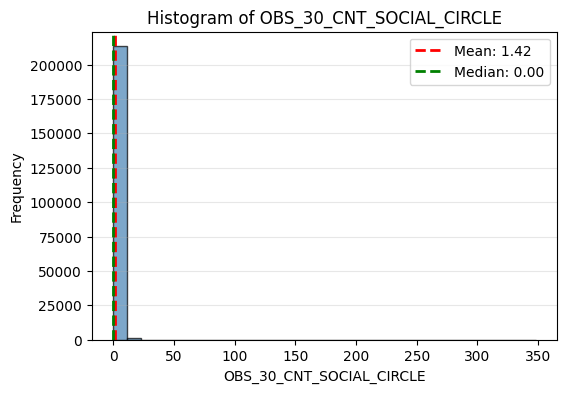

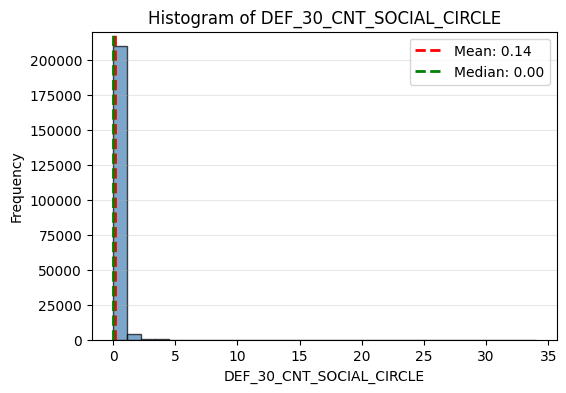

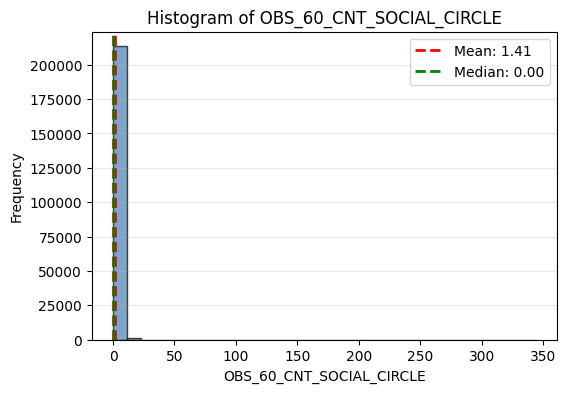

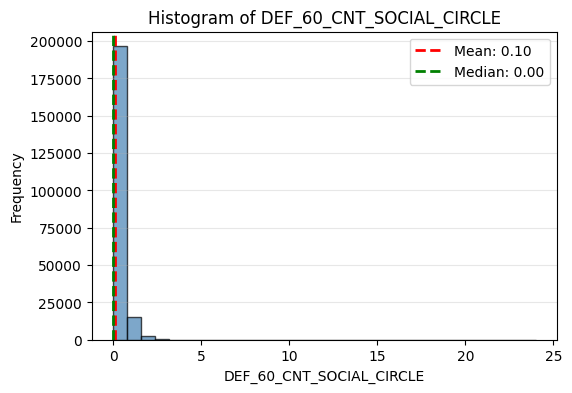

In [250]:
# Vẽ histogram cho các biến rời rạc Social Circle

cols_social = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

for col in cols_social:
    plot_continuous_histogram(df[col], bins=30, title=f'Histogram of {col}', figsize=(6,4))

#### Đánh giá
- Tất cả các biến Vòng tròn Xã hội, giá trị Median (Trung vị) bằng 0.00. Điều này có nghĩa là hơn 50% khách hàng có 0 người trong vòng tròn xã hội đã được quan sát hoặc đã mặc định.

- Phân phối bị lệch phải cực mạnh (có một đuôi dài ở phía giá trị dương lớn hơn), cho thấy chỉ có một số ít khách hàng có giá trị cao (có nhiều bạn bè/người quen bị mặc định)

- Mặc dù số lượng người mặc định (DEF_30/60) là thấp (Mean chỉ 0.10 - 0.14), những trường hợp có giá trị DEF_CNT_SOCIAL_CIRCLE $> 0$ có thể là chỉ báo rủi ro rất mạnh, vì họ đi ngược lại xu hướng chung của dữ liệu.

In [251]:
# Metrics cho các biến social circle
results = []
for col in cols_social:
    metrics = calculate_continuous_metrics(df[col])
    results.append(metrics)
metrics_df = pd.concat(results, ignore_index=True)
metrics_df

,Feature,Count,Missing,Mean,Median,Std,Min,Max,Skewness,Kurtosis
0,OBS_30_CNT_SOCIAL_CIRCLE,214546,712,1.424347,0.0,2.435066,0.0,348.0,15.666742,1920.360301
1,DEF_30_CNT_SOCIAL_CIRCLE,214546,712,0.143992,0.0,0.449188,0.0,34.0,5.693834,168.454756
2,OBS_60_CNT_SOCIAL_CIRCLE,214546,712,1.407474,0.0,2.413607,0.0,344.0,15.568267,1899.842326
3,DEF_60_CNT_SOCIAL_CIRCLE,214546,712,0.100104,0.0,0.362889,0.0,24.0,5.599018,111.578078


#### Bivariate Analysis vs Target

Biểu đồ

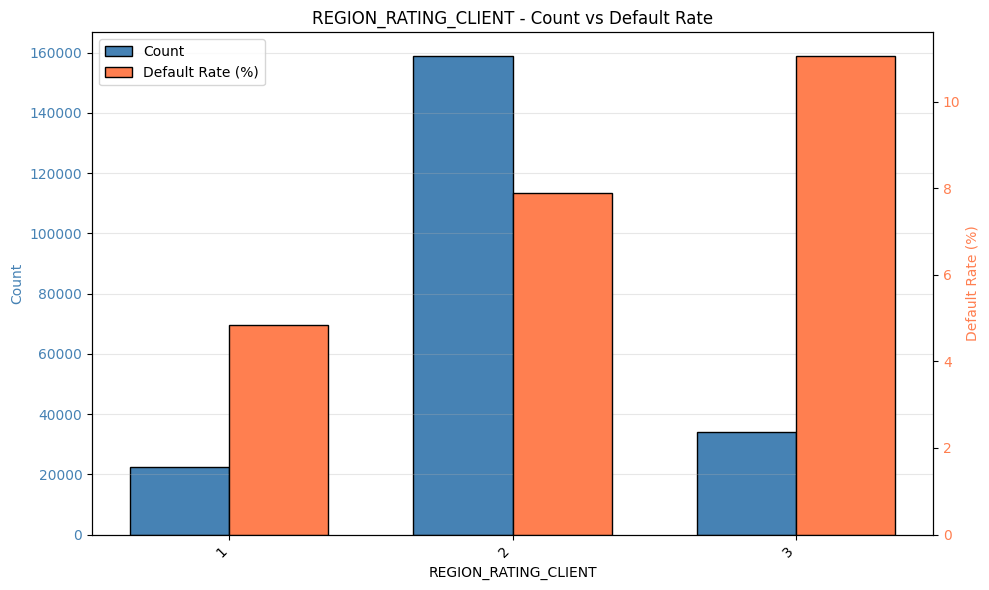

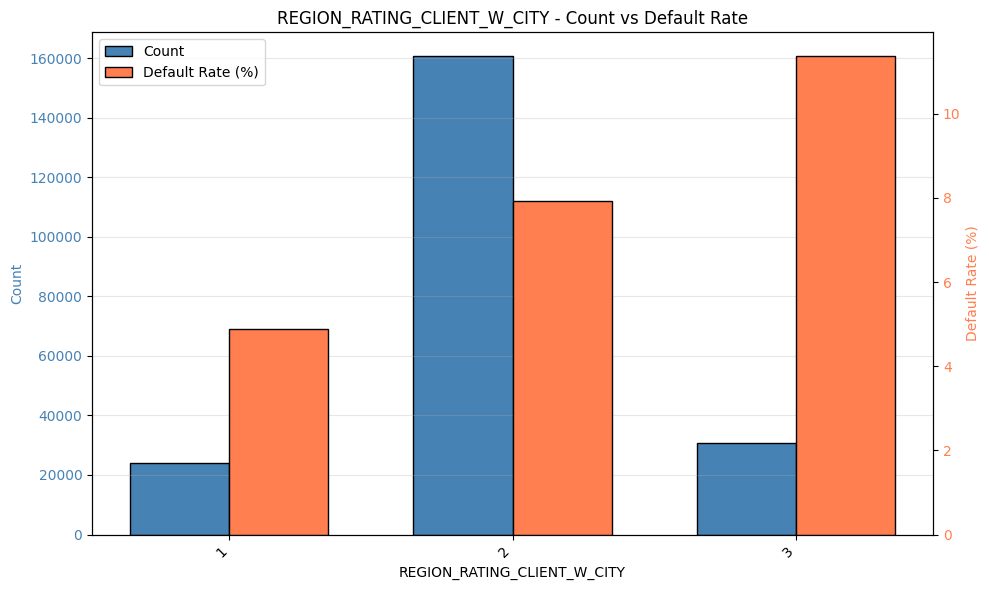

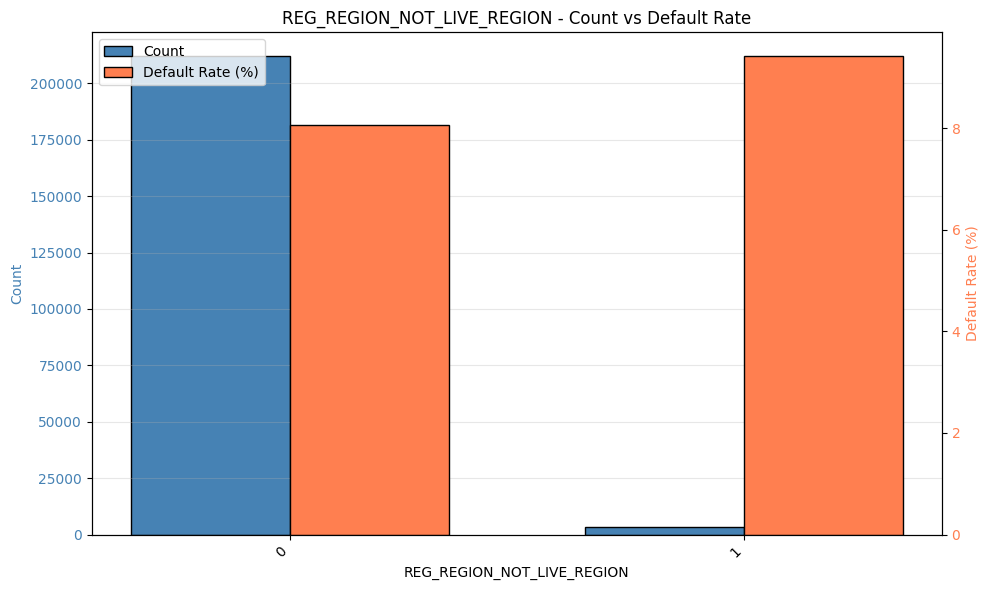

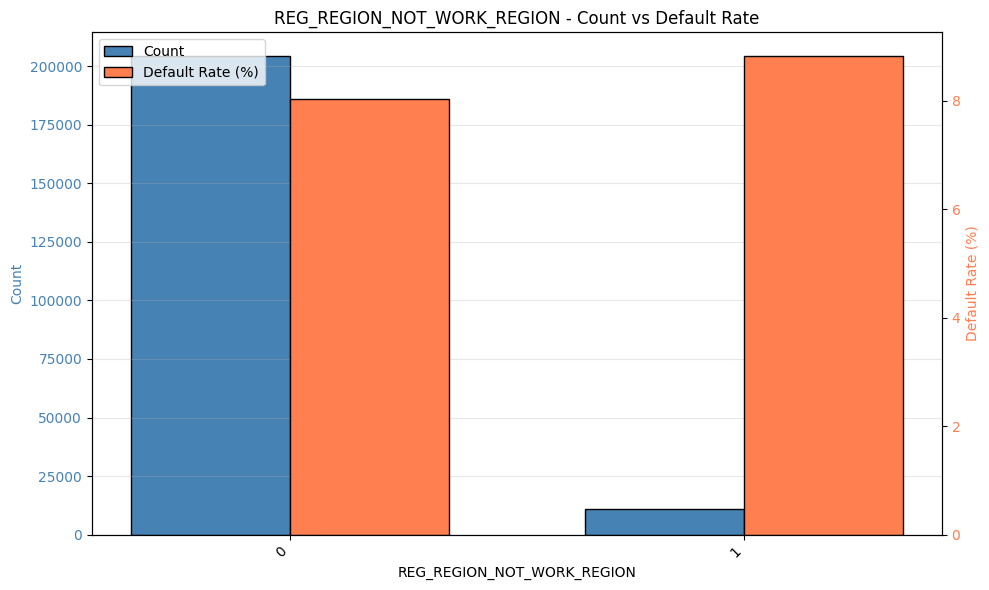

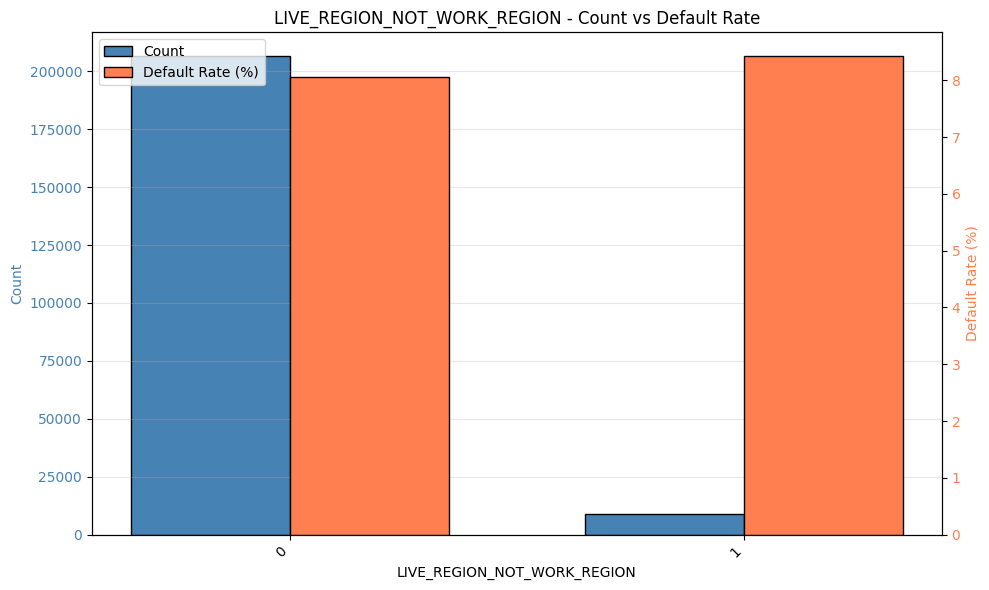

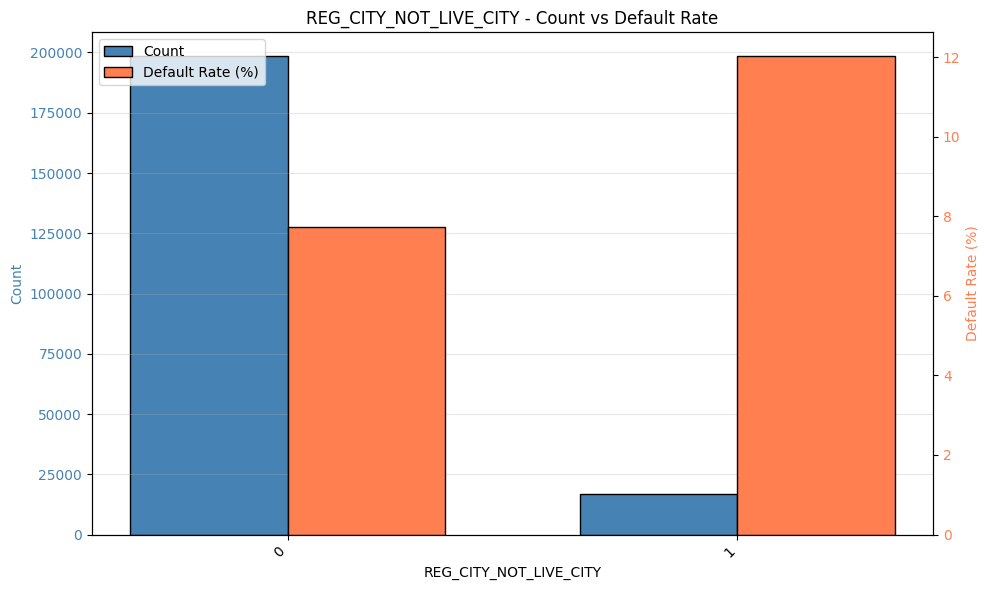

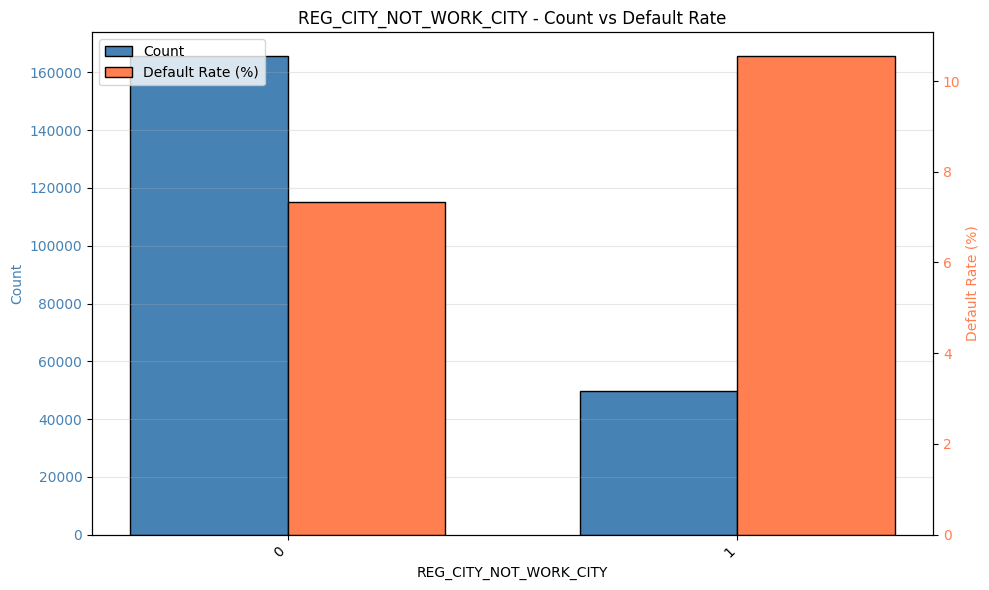

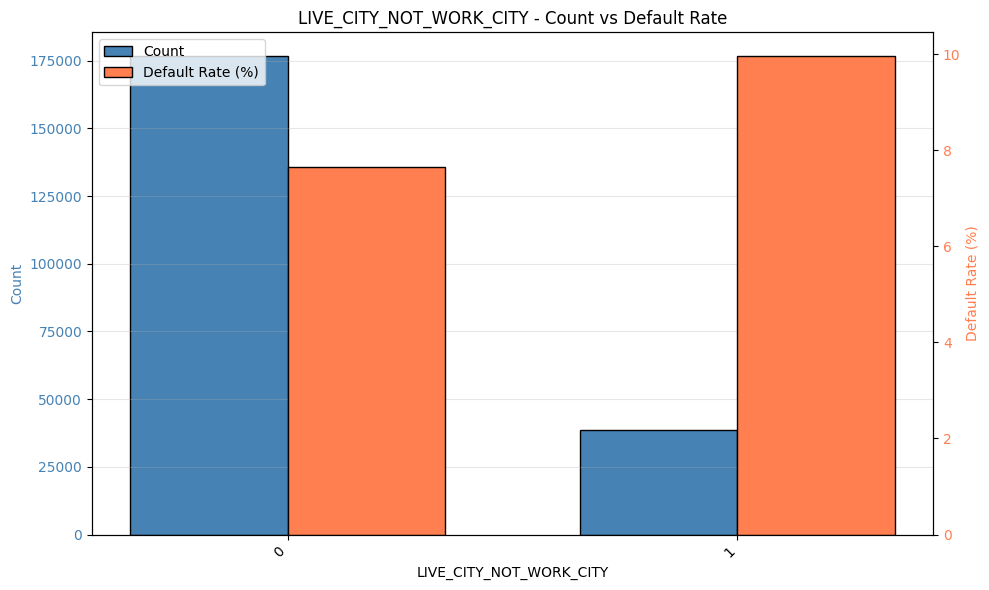

In [252]:
# Grouped Bar Chart (Discrete value vs Default rate)
# Vẽ grouped bar chart cho các biến rời rạc ít giá trị
for col in cols_live:
    plot_grouped_bar_vs_target(df, feature=col, target='TARGET', 
                               title=f'{col} - Count vs Default Rate', figsize=(10,6))

#### Đánh giá
- Các biểu đồ REGION_RATING_CLIENT và REGION_RATING_CLIENT_W_CITY cho thấy một mối quan hệ tỷ lệ nghịch rất rõ ràng. Khi đánh giá vùng kém đi (giá trị tăng từ 1 lên 3), tỷ lệ Mặc định tăng lên một cách đáng kể. Khách hàng ở vùng có đánh giá $\text{3}$ có nguy cơ mặc định cao gần gấp đôi so với khách hàng ở vùng $\text{1}$. Ngoài ra, tỷ lệ mặc định ở các cấp độ 1, 2, 3 của REGION_RATING_CLIENT_W_CITY gần như giống hệt với REGION_RATING_CLIENT. ==> Điều này cho thấy việc thêm yếu tố thành phố vào đánh giá (W_CITY) không cải thiện đáng kể khả năng phân biệt rủi ro so với đánh giá vùng đơn thuần.

- Về REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, REG_CITY_NOT_LIVE_CITY: có sự khác biệt giữa nơi Đăng ký và nơi Sống/Làm việc tại thành phố khác là một rào cản tâm lý hoặc dấu hiệu bất ổn và làm tăng nguy cơ mặc định lên đáng kể.

- Về REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_REGION_NOT_LIVE_REGION: Tỷ lệ mặc định của nhóm 0 là ổn định ($\approx 8\%$).  Tương tự như City, khi có sự khác biệt về Vùng (1), tỷ lệ mặc định tăng vọt lên $\approx 10.0 - 12.0\%$.Tuy nhiên, các biến REGION này có rất ít trường hợp $\text{1}$ (dưới 11,000). Mặc dù tỷ lệ mặc định cao, chúng chỉ áp dụng cho một phần rất nhỏ của tập dữ liệu.

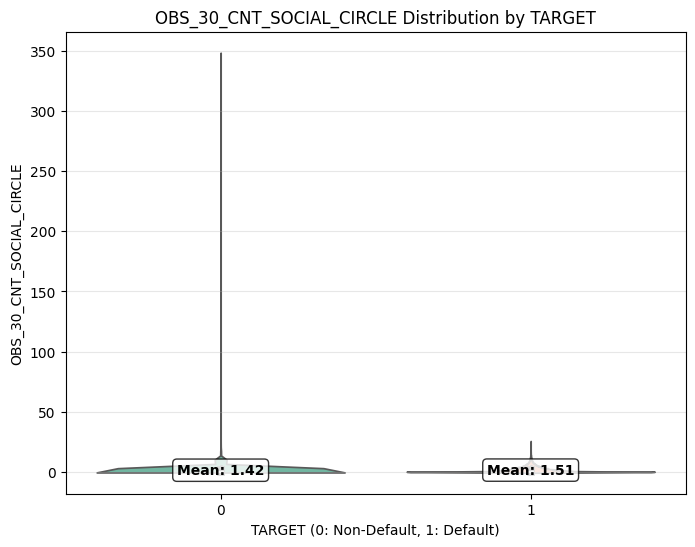

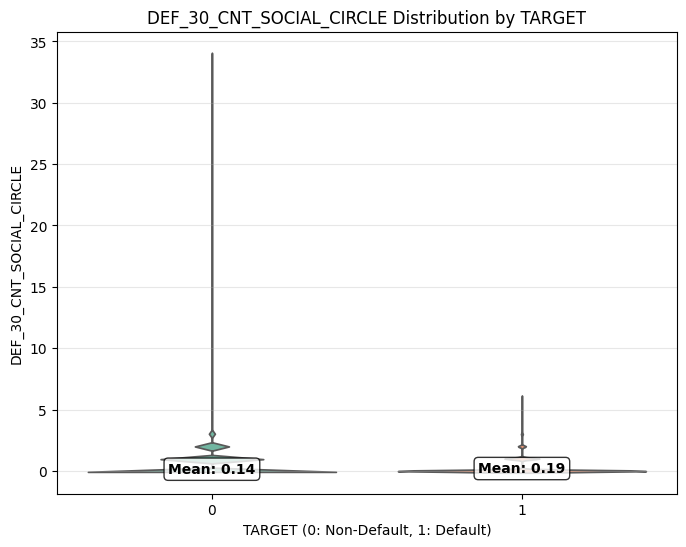

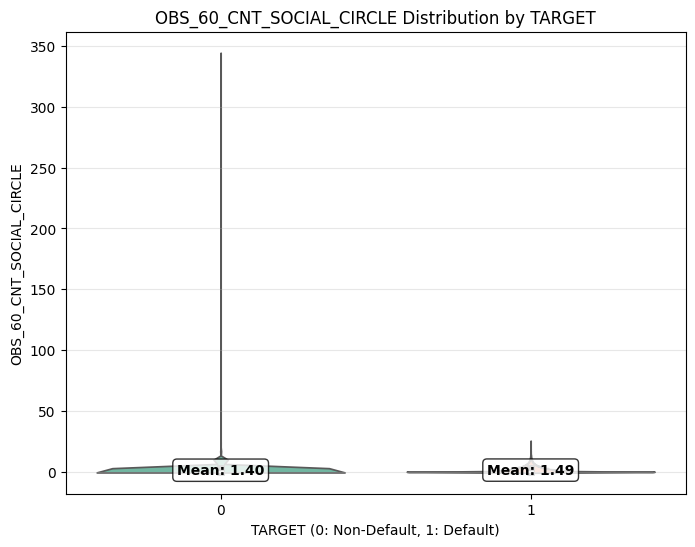

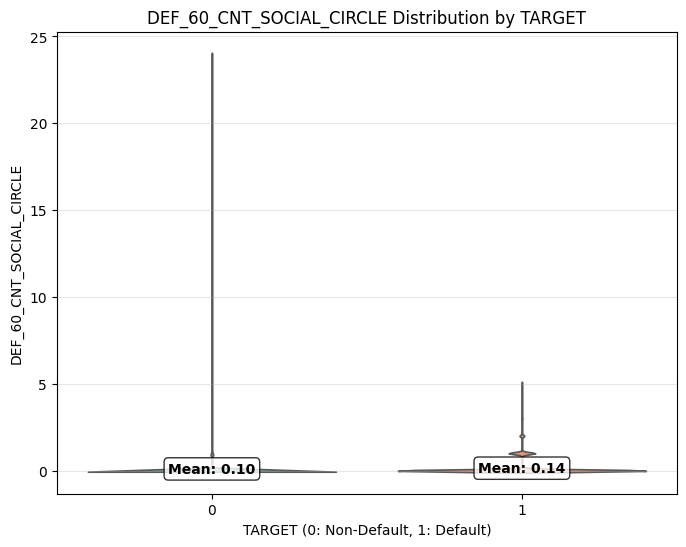

In [253]:
# Biểu đồ cho các biến Social Circle vs target
for col in cols_social:
    plot_continuous_violin_vs_target(df, feature=col, target='TARGET', 
                                    title=f'{col} Distribution by TARGET', figsize=(8,6))

Metrics

In [254]:
# Tính metrics quan hệ với TARGET cho biến discrete ít giá trị
# Chạy cho tất cả discrete features ít giá trị
results = []
for col in cols_live:
    metrics = calculate_target_relationship_nominal(df, feature=col, target='TARGET')
    results.append(metrics)
relationship_df = pd.concat(results, ignore_index=True)
relationship_df

,Feature,Unique_Values,Chi2_Statistic,Chi2_P_Value,Cramers_V,Information_Value,Mutual_Information
0,REGION_RATING_CLIENT,3,728.448691,6.597457e-159,0.058173,0.047135,0.001716
1,REGION_RATING_CLIENT_W_CITY,3,783.287842,8.150912e-171,0.060323,0.050022,0.001828
2,REG_REGION_NOT_LIVE_REGION,2,7.857697,5.060481e-03,0.006042,0.000467,0.000018
3,REG_REGION_NOT_WORK_REGION,2,8.491121,3.568839e-03,0.006281,0.000517,0.000019
4,LIVE_REGION_NOT_WORK_REGION,2,1.466232,2.259412e-01,0.002610,0.000093,0.000003
5,REG_CITY_NOT_LIVE_CITY,2,383.028703,2.726289e-85,0.042183,0.020284,0.000793
6,REG_CITY_NOT_WORK_CITY,2,531.480541,1.345396e-117,0.049689,0.030651,0.001167
7,LIVE_CITY_NOT_WORK_CITY,2,225.194070,6.660136e-51,0.032344,0.013103,0.000498


#### Đánh giá

1. Information Value (IV):

- IV score chỉ rơi vào khoảng $0.02$ - $0.1$ ( mức trung bình, tốt) và $< 0.02$ ( yếu).

- REGION_RATING_CLIENT_W_CITY (IV $\approx 0.050$): Là biến phân loại mạnh nhất theo tất cả các metrics (Cramer's V, IV). 

- REGION_RATING_CLIENT (IV $\approx 0.047$): Gần như tương đương.

- REG_CITY_NOT_WORK_CITY (IV $\approx 0.030$): Ở mức tốt, đây là chỉ báo rủi ro quan trọng trong nhóm chênh lệch địa lý.

- Các biến còn lại khá thấp, đặc biệt 3 biến _REGION gần như bằng 0.

2. Mutual Information: Giá trị $\text{MI}$ càng cao thì khả năng giảm sự không chắc chắn về $\text{TARGET}$ càng lớn

Thứ tự $\text{MI}$: Thứ tự $\text{MI}$ hoàn toàn trùng khớp với $\text{Cramer's V}$ và $\text{IV}$.

- Cao nhất: $\text{REGION\_RATING\_CLIENT\_W\_CITY} (\approx 0.0018)$

- Trung bình: $\text{REG\_CITY\_NOT\_WORK\_CITY} (\approx 0.0011)$

- Thấp nhất: $\text{LIVE\_REGION\_NOT\_WORK\_REGION} (\approx 0.000003)$

==> Cả ba chỉ số (Cramer's V, IV, MI) đều đồng nhất trong việc xếp hạng các biến. 

==> Giữ lại: $\text{REGION\_RATING\_CLIENT\_W\_CITY}$, $\text{REG\_CITY\_NOT\_WORK\_CITY}$, $\text{REG\_CITY\_NOT\_LIVE\_CITY}$ ( có thể)
   
   Bỏ : Mấy cái còn lại



In [255]:
# Tính metrics quan hệ với TARGET cho biến discrete nhiều giá trị    
# Chạy cho tất cả discrete features nhiều giá trị
results = []
for col in cols_social:
    metrics = calculate_target_relationship_continuous(df, feature=col, target='TARGET')
    results.append(metrics)
relationship_df1 = pd.concat(results, ignore_index=True)
relationship_df1

,Feature,Point_Biserial_Correlation,Point_Biserial_P_Value,ANOVA_F_Statistic,ANOVA_P_Value
0,OBS_30_CNT_SOCIAL_CIRCLE,0.009922,4.311000e-06,21.122431,4.311000e-06
1,DEF_30_CNT_SOCIAL_CIRCLE,0.033007,8.547962e-53,233.995891,8.547962e-53
2,OBS_60_CNT_SOCIAL_CIRCLE,0.009754,6.246421e-06,20.412186,6.246421e-06
3,DEF_60_CNT_SOCIAL_CIRCLE,0.032405,5.983527e-51,225.526368,5.983527e-51


#### Đánh Giá  


In [256]:
# Information Value (IV)
for col in cols_social:
    iv_df = calculate_iv(df, feature=col, target='TARGET')
    print(f"\nInformation Value for {col}:")
    print(iv_df)


Information Value for OBS_30_CNT_SOCIAL_CIRCLE:
0.0029880229872754046

Information Value for DEF_30_CNT_SOCIAL_CIRCLE:
0.013534642065710943

Information Value for OBS_60_CNT_SOCIAL_CIRCLE:
0.002879227929380149

Information Value for DEF_60_CNT_SOCIAL_CIRCLE:
0.012630478527417109


#### * Multivariate Analysis

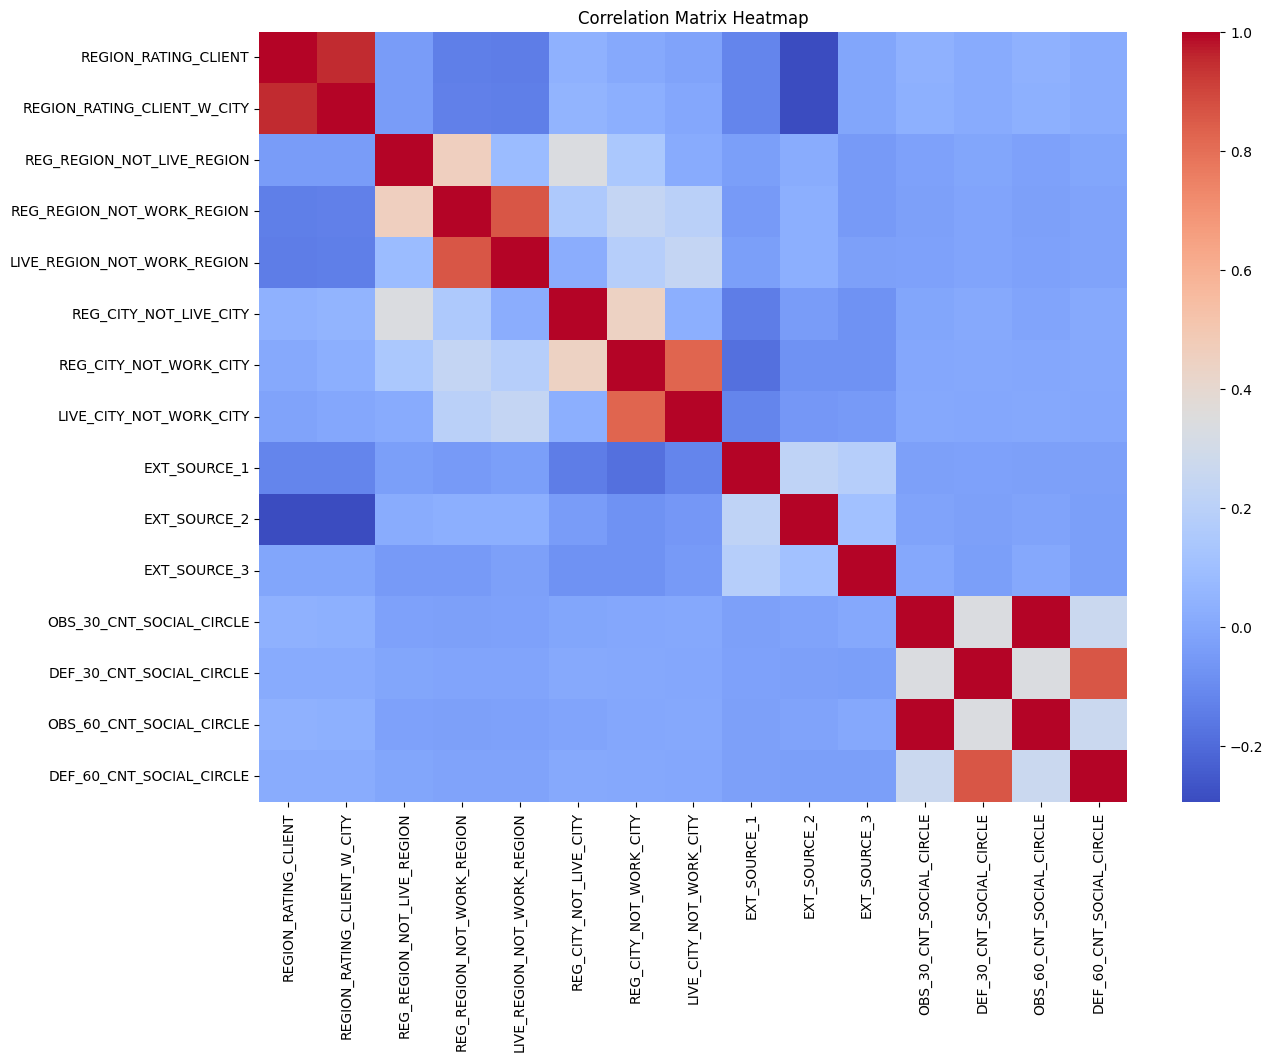

In [257]:
# CORRELATION MATRIX – HEATMAP
plt.figure(figsize=(14, 10))
corr = df_list[feature_list].corr()

sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix Heatmap")
plt.show()

[LightGBM] [Info] Number of positive: 17378, number of negative: 197880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 215258, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432456
[LightGBM] [Info] Start training from score -2.432456


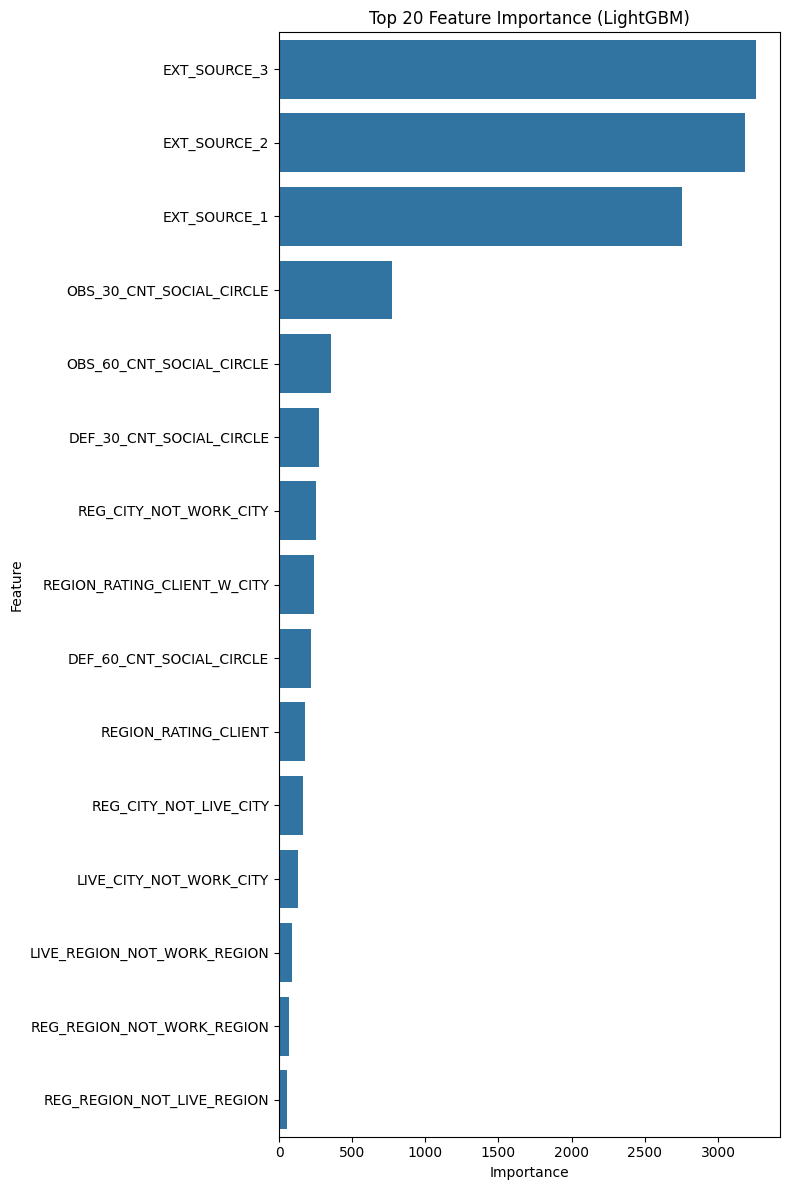

In [258]:
# FEATURE IMPORTANCE – TOP 20
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)

X = df[feature_list]
y = df['TARGET']

model.fit(X, y)

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(8, 12))
sns.barplot(data=feat_imp.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importance (LightGBM)")
plt.tight_layout()
plt.show()


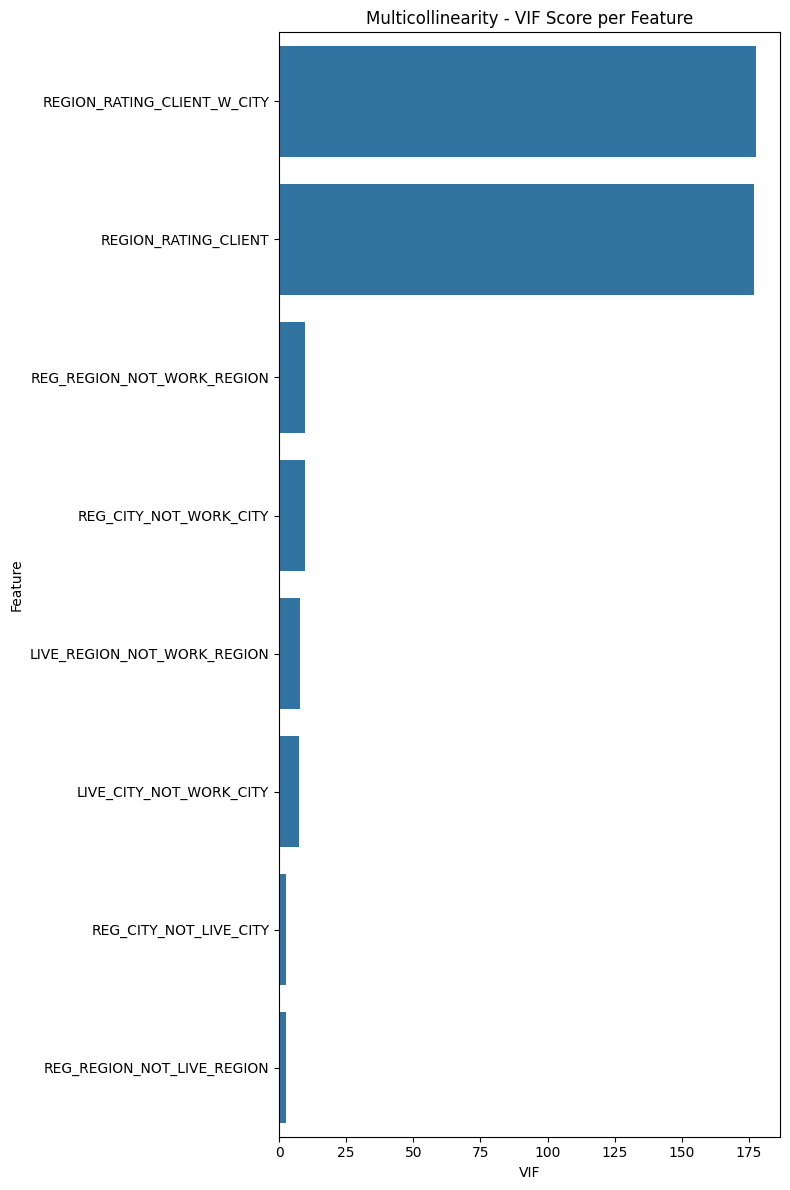

In [259]:
# MULTICOLLINEARITY – VIF Bar Chart
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Tính VIF cho numeric features

vif_df = pd.DataFrame()
vif_df['Feature'] = df[cols_live].columns
vif_df['VIF'] = [variance_inflation_factor(df[cols_live].values, i) 
                 for i in range(df[cols_live].shape[1])]

# Plot VIF
vif_df_sorted = vif_df.sort_values(by='VIF', ascending=False)

plt.figure(figsize=(8, 12))
sns.barplot(data=vif_df_sorted, x='VIF', y='Feature')
plt.title("Multicollinearity - VIF Score per Feature")
plt.tight_layout()
plt.show()

# Data Cleaning #

## * Xử lí missing values và ouliers

In [ ]:
# Xử lí các biến Ext_source
# Không có ouliers nên chỉ xử lí missing values
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ext_cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

imp = SimpleImputer(strategy="median")
df_ext = pd.DataFrame(imp.fit_transform(df[ext_cols]), columns=ext_cols)

df[ext_cols] = df_ext

# Gộp lại thành 1 feature EXT_SOURCE bằng mean
df["EXT_SOURCE"] = df_ext.mean(axis=1)

# Xóa 3 cột gốc
df.drop(columns=ext_cols, inplace=True)
# Thông tin cột mới và missing
print(df["EXT_SOURCE"].describe())
print("Missing values in EXT_SOURCE:", df["EXT_SOURCE"].isnull().sum())


count    2.152580e+05
mean     3.951164e-17
std      1.109253e+00
min     -5.083502e+00
25%     -7.007962e-01
50%      8.623190e-02
75%      7.404335e-01
max      3.624953e+00
Name: EXT_SOURCE, dtype: float64
Missing values in EXT_SOURCE: 0


In [261]:
# Check số lượng giá trị trong biến để xem có outliers không
for col in cols_social:
    value_counts = df[col].value_counts().sort_index()
    print(f"\nValue counts for {col}:")
    print(value_counts)


Value counts for OBS_30_CNT_SOCIAL_CIRCLE:
OBS_30_CNT_SOCIAL_CIRCLE
0.0      114671
1.0       33964
2.0       20983
3.0       14359
4.0        9962
5.0        6667
6.0        4471
7.0        3080
8.0        2071
9.0        1416
10.0        952
11.0        600
12.0        464
13.0        273
14.0        180
15.0        122
16.0         94
17.0         65
18.0         32
19.0         30
20.0         20
21.0         22
22.0         17
23.0          8
24.0          6
25.0          5
26.0          2
27.0          5
28.0          1
29.0          1
30.0          1
47.0          1
348.0         1
Name: count, dtype: int64

Value counts for DEF_30_CNT_SOCIAL_CIRCLE:
DEF_30_CNT_SOCIAL_CIRCLE
0.0     189861
1.0      19849
2.0       3771
3.0        844
4.0        174
5.0         39
6.0          5
7.0          1
8.0          1
34.0         1
Name: count, dtype: int64

Value counts for OBS_60_CNT_SOCIAL_CIRCLE:
OBS_60_CNT_SOCIAL_CIRCLE
0.0      115200
1.0       34034
2.0       20947
3.0       14273

In [262]:
# Xử lí ouliers cho các biến Social Circle
social_cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

# HÀM CAP OUTLIER BẰNG Winsorizing 1 phía ( P99)
def cap_percentile(series, p=0.99):
    upper = series.quantile(p)
    return series.clip(upper=upper)

for col in cols_social:
    df[col] = cap_percentile(df[col])

# Kiểm tra lại số lượng giá trị sau khi cap outliers
for col in cols_social:
    value_counts = df[col].value_counts().sort_index()
    print(f"\nValue counts for {col} after capping:")
    print(value_counts)



Value counts for OBS_30_CNT_SOCIAL_CIRCLE after capping:
OBS_30_CNT_SOCIAL_CIRCLE
0.0     114671
1.0      33964
2.0      20983
3.0      14359
4.0       9962
5.0       6667
6.0       4471
7.0       3080
8.0       2071
9.0       1416
10.0      2902
Name: count, dtype: int64

Value counts for DEF_30_CNT_SOCIAL_CIRCLE after capping:
DEF_30_CNT_SOCIAL_CIRCLE
0.0    189861
1.0     19849
2.0      4836
Name: count, dtype: int64

Value counts for OBS_60_CNT_SOCIAL_CIRCLE after capping:
OBS_60_CNT_SOCIAL_CIRCLE
0.0     115200
1.0      34034
2.0      20947
3.0      14273
4.0       9830
5.0       6601
6.0       4395
7.0       3051
8.0       2025
9.0       1379
10.0      2811
Name: count, dtype: int64

Value counts for DEF_60_CNT_SOCIAL_CIRCLE after capping:
DEF_60_CNT_SOCIAL_CIRCLE
0.0    196500
1.0     15271
2.0      2775
Name: count, dtype: int64


In [264]:
# Xử lí missing values cho các biến Social Circle bằng KNN Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer

class SocialCircleKNNImputer(BaseEstimator, TransformerMixin):
    """
    KNN Imputation cho các biến Social Circle:
    - OBS_30_CNT_SOCIAL_CIRCLE
    - OBS_60_CNT_SOCIAL_CIRCLE
    - DEF_30_CNT_SOCIAL_CIRCLE
    - DEF_60_CNT_SOCIAL_CIRCLE
    """
    def __init__(self, k=5, top_n=5):
        self.k = k
        self.top_n = top_n
        self.social_cols = social_cols
        self.top_features_ = None
        self.knn_input_cols_ = None
        self.knn_imputer_ = None

    def fit(self, X, y=None):
        corr = X.corr(numeric_only=True)[self.social_cols]

        top_features = set()
        for col in self.social_cols:
            top_corr = corr[col].drop(self.social_cols, errors="ignore")
            top_n_feats = top_corr.abs().nlargest(self.top_n).index.tolist()
            top_features.update(top_n_feats)

        self.top_features_ = list(top_features)
        print("Top correlated features used for KNN:", self.top_features_)

        self.knn_input_cols_ = self.social_cols + self.top_features_

        self.knn_imputer_ = KNNImputer(n_neighbors=self.k)
        self.knn_imputer_.fit(X[self.knn_input_cols_])

        return self

    def transform(self, X):
        X = X.copy()

        knn_df = X[self.knn_input_cols_].copy()
        imputed_arr = self.knn_imputer_.transform(knn_df)
        imputed_df = pd.DataFrame(imputed_arr, columns=self.knn_input_cols_, index=X.index)

        X[self.social_cols] = imputed_df[self.social_cols]

        return X

# Fit + transform
imputer = SocialCircleKNNImputer(k=5, top_n=5)
imputer.fit(df)
df[cols_social] = imputer.transform(df)[cols_social]

# Làm tròn các biến social circle về kiểu int
for col in social_cols:
    df[col] = df[col].round().astype(int)
print("\nMissing values AFTER KNN Imputation:")
print(df[social_cols].isna().sum())

Top correlated features used for KNN: ['FLAG_PHONE', 'REG_REGION_NOT_WORK_REGION', 'TARGET', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_8', 'EXT_SOURCE', 'REGION_RATING_CLIENT']

Missing values AFTER KNN Imputation:
OBS_30_CNT_SOCIAL_CIRCLE    0
DEF_30_CNT_SOCIAL_CIRCLE    0
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
dtype: int64


Các biến rời rạc như biến xếp hạng (REGION_RATING_CLIENT) và biến cờ nhị phân (REG_REGION_NOT_LIVE_REGION, v.v.) cho kết quả IQR = 0 do sự tập trung dữ liệu tại một giá trị phổ biến (Mode). Điều này khiến phương pháp IQR xác định các giá trị hợp lệ, mang thông tin (ví dụ: Rating 1/3, Flag 1) là outliers ==> giữ nguyên tất cả các giá trị này vì chúng đại diện cho các nhóm khách hàng quan trọng (rủi ro cao hoặc rủi ro thấp) và không phải là lỗi dữ liệu cần loại bỏ.

### * CÁC BIẾN SOCIAL SAU XỬ LÍ OULIERS/MISSING

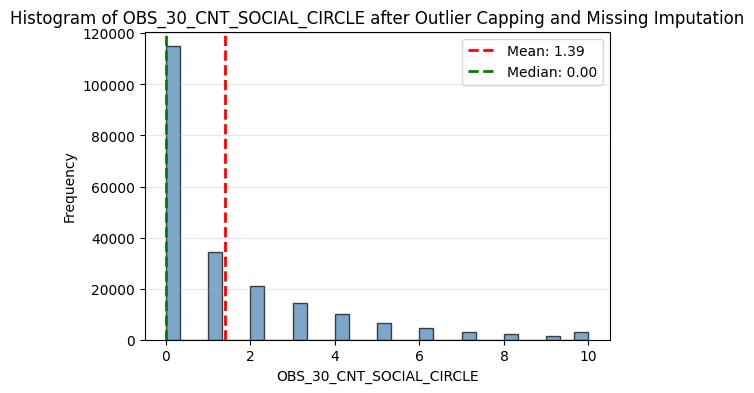

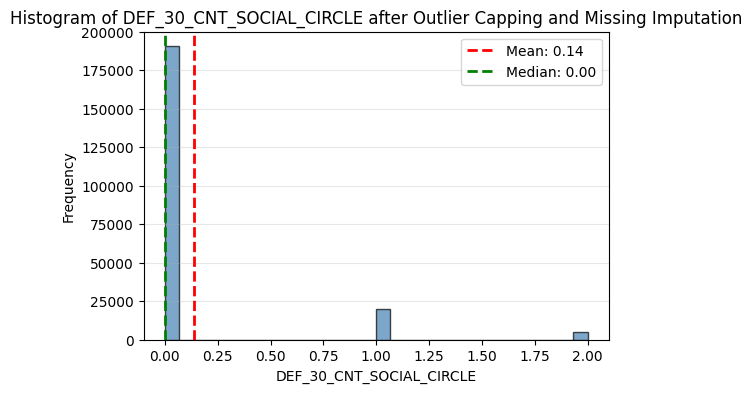

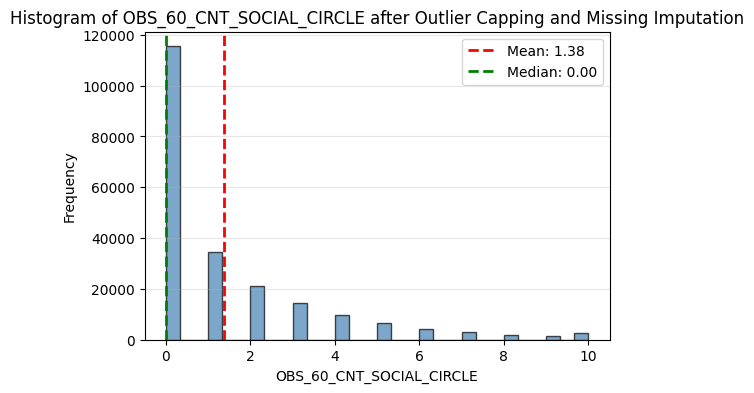

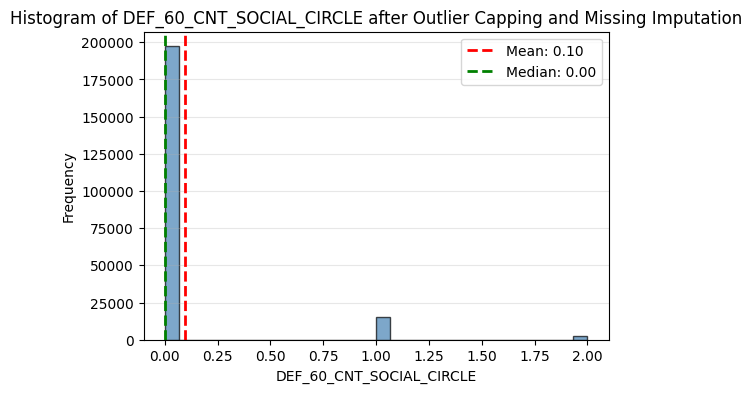

In [265]:
# Vẽ lại biểu đồ cho các biến Social Circle sau khi xử lí outliers và missing values
for col in cols_social:
    plot_continuous_histogram(df[col], bins=30, title=f'Histogram of {col} after Outlier Capping and Missing Imputation', figsize=(6,4))

Insight:

- Đây là các chỉ số rủi ro lan truyền, đo lường tình trạng tín dụng của người quen/ người có liên kết xã hội với khách hàng.

- Lý do Home Credit tạo ra biến này: trong tín dụng vi mô, khách hàng có xu hướng chịu ảnh hưởng tài chính từ gia đình / bạn bè → rủi ro "cluster default" (vỡ nợ theo nhóm).
    - Hiệu ứng “rủi ro theo cụm xã hội”: Người quen vỡ nợ phản ánh mức độ bất ổn tài chính trong cộng đồng.

    - Khả năng lan truyền rủi ro: Người trong nhóm có thể vay mượn chéo, phụ thuộc lẫn nhau → tổn thương tài chính cao hơn.

    - Đặc biệt hiệu quả đối với khách hàng không có lịch sử tín dụng → giúp mô hình vẫn dự đoán tốt dựa vào thông tin cộng đồng.

- Giá trị lớn → nhóm xã hội của khách hàng có rủi ro cao → khả năng khách vỡ nợ cũng cao

In [268]:
# Metrics cho các biến social circle sau khi xử lí
results = []
for col in social_cols:
    metrics = calculate_continuous_metrics(df[col])
    results.append(metrics)
metrics_df = pd.concat(results, ignore_index=True)
metrics_df

,Feature,Count,Missing,Mean,Median,Std,Min,Max,Skewness,Kurtosis
0,OBS_30_CNT_SOCIAL_CIRCLE,215258,0,1.392246,0.0,2.162704,0,10,1.972487,3.754345
1,DEF_30_CNT_SOCIAL_CIRCLE,215258,0,0.137245,0.0,0.404155,0,2,3.062994,9.066994
2,OBS_60_CNT_SOCIAL_CIRCLE,215258,0,1.376455,0.0,2.147139,0,10,1.987317,3.837724
3,DEF_60_CNT_SOCIAL_CIRCLE,215258,0,0.096777,0.0,0.336444,0,2,3.685484,13.895188


,Feature,Point_Biserial_Correlation,Point_Biserial_P_Value,ANOVA_F_Statistic,ANOVA_P_Value
0,OBS_30_CNT_SOCIAL_CIRCLE,0.011288,1.629960e-07,27.430491,1.629960e-07
1,DEF_30_CNT_SOCIAL_CIRCLE,0.034049,3.019688e-56,249.844916,3.019688e-56
2,OBS_60_CNT_SOCIAL_CIRCLE,0.011119,2.485718e-07,26.614659,2.485718e-07
3,DEF_60_CNT_SOCIAL_CIRCLE,0.033058,4.030014e-53,235.494620,4.030014e-53


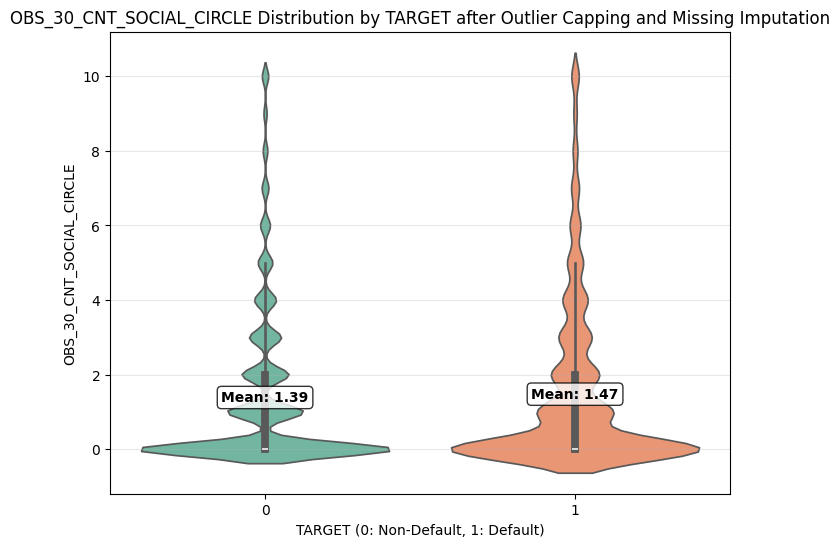

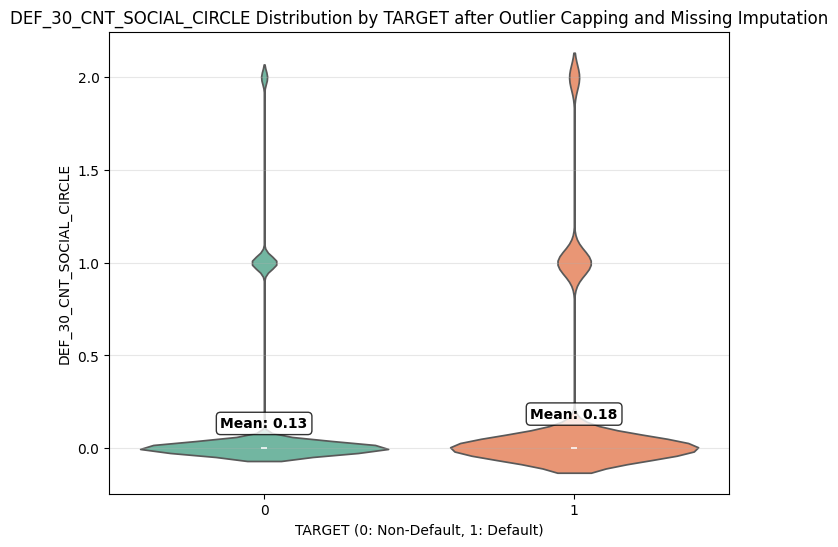

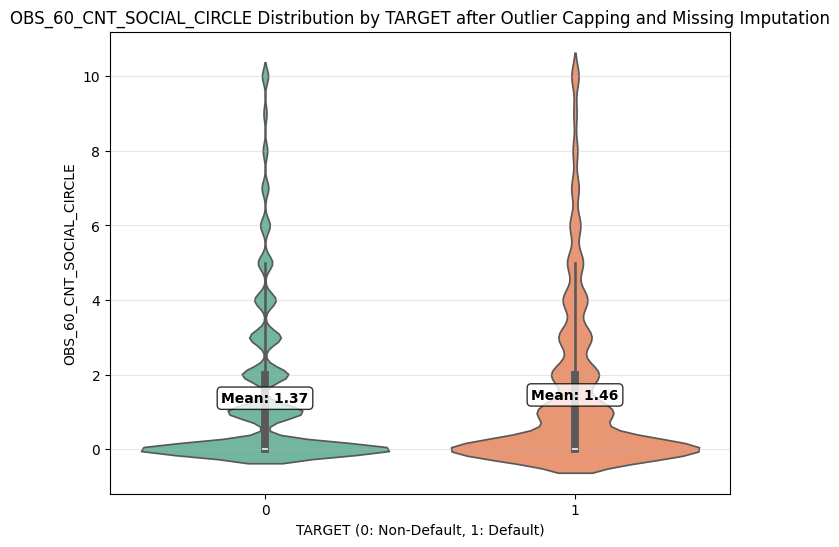

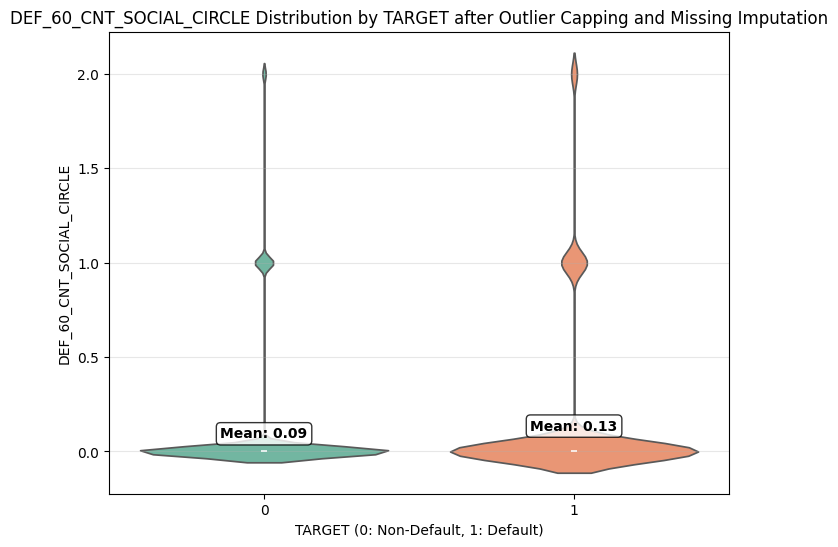

In [269]:
# Vẽ lại biểu đồ và metrics sau khi xử lí outliers và missing values cho các biến social circle so với TARGET
results = []
for col in cols_social:
    plot_continuous_violin_vs_target(df, feature=col, target='TARGET', 
                                    title=f'{col} Distribution by TARGET after Outlier Capping and Missing Imputation', figsize=(8,6))
    metrics = calculate_target_relationship_continuous(df, feature=col, target='TARGET')
    results.append(metrics)
relationship_df1 = pd.concat(results, ignore_index=True)
relationship_df1

Insight:
- Khi các chỉ số DEF/OBS tăng lên, xác suất vỡ nợ của khách hàng tăng đáng kể.

- Phân phối theo TARGET cho thấy:

     - Nhóm TARGET=1 (vỡ nợ) thường có OBS/DEF cao hơn.

     - Nhóm TARGET=0 (trả nợ) tập trung nhiều ở mức 0 → rất ít người quen có lịch sử nợ xấu.

- Mối quan hệ dạng tuyến tính yếu nhưng hướng tăng rủi ro rất rõ.

### * BIẾN EXT_SOURCE SAU XỬ LÍ OULIERS/MISSING

,Feature,Count,Missing,Mean,Median,Std,Min,Max,Skewness,Kurtosis
0,EXT_SOURCE,215258,0,3.951164e-17,0.086232,1.109253,-5.083502,3.624953,-0.320583,0.273783


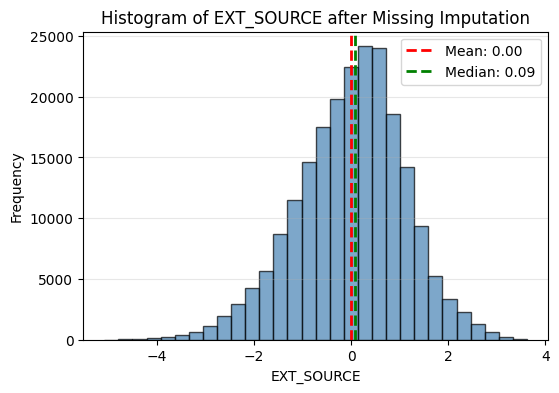

In [270]:
# Vẽ lại biểu đồ và metrics sau khi xử lí cho EXT_SOURCE
plot_continuous_histogram(df["EXT_SOURCE"], title='Histogram of EXT_SOURCE after Missing Imputation', figsize=(6,4))
metrics = calculate_continuous_metrics(df["EXT_SOURCE"])
metrics

.Insights:

- EXT_SOURCE là điểm tín dụng tổng hợp từ nguồn bên ngoài, phản ánh lịch sử tín dụng – độ uy tín tài chính – kỷ luật trả nợ.

- Vì tương quan âm mạnh → nó giúp nhận biết khách hàng rủi ro thấp một cách rõ ràng ( giá trị EXT_SOURCE càng cao → rủi ro vỡ nợ càng thấp)→ cực quan trọng khi cho vay vi mô (microfinance) vốn nhắm tới nhóm khách hàng thiếu dữ liệu.

- Đây là dạng feature mang thông tin “tín hiệu bên ngoài”, bổ sung cho dữ liệu nội bộ vốn hạn chế.

,Feature,Point_Biserial_Correlation,Point_Biserial_P_Value,ANOVA_F_Statistic,ANOVA_P_Value
0,EXT_SOURCE,-0.213341,0.0,10264.466251,0.0


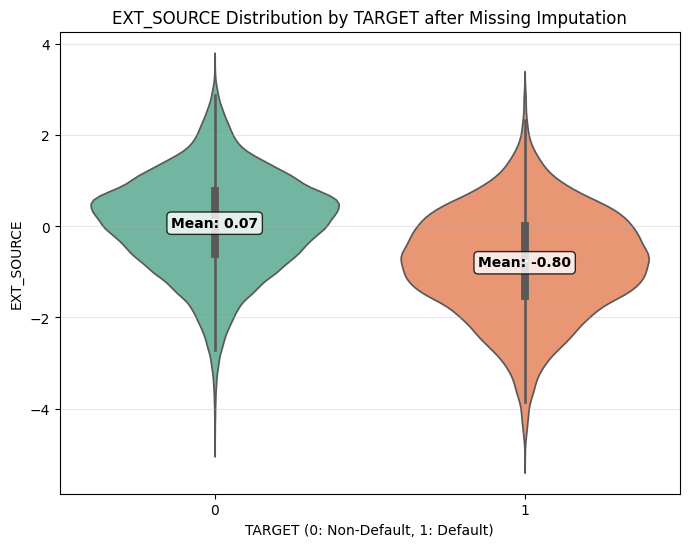

In [272]:
# Vẽ lại biểu đồ và metrics sau xử lí cho biến EXT_SOURCE so với TARGET
plot_continuous_violin_vs_target(df, feature="EXT_SOURCE", target='TARGET', 
                                title='EXT_SOURCE Distribution by TARGET after Missing Imputation', figsize=(8,6))
metrics = calculate_target_relationship_continuous(df, feature="EXT_SOURCE", target='TARGET')
metrics

Insight:

- Sau khi xử lý missing, EXT_SOURCE phản ánh đúng bản chất đánh giá rủi ro: score càng lớn thì tỷ lệ default giảm rõ ràng. Noise từ missing không còn làm nhiễu mẫu.

- Outlier được loại bỏ giúp phân phối EXT_SOURCE ổn định hơn, loại bỏ các điểm cực đoan gây chia nhánh sai trong tree model và làm linear model bị lệch

- Việc giảm skewness khiến EXT_SOURCE dễ được mô hình tiếp nhận hơn, đặc biệt là hồi quy logistic và các mô hình tuyến tính.

- Sau xử lý, EXT_SOURCE thể hiện mối quan hệ đơn điệu với khả năng vỡ nợ: score càng cao → rủi ro càng thấp. Đây là mô hình lý tưởng để sử dụng trong credit scoring.




# Data Transforming #

Các biến Flag\Binary đã ở dạng số (0/1) và trên cùng thang đo (Binary), không cần Scaling hay Encoding.

In [273]:
# Feature Scaling cho EXT_SOURCE 
from sklearn.preprocessing import StandardScaler

# Trước khi scaling
print(df["EXT_SOURCE"].describe())

scaler = StandardScaler()
df["EXT_SOURCE"] = scaler.fit_transform(df[["EXT_SOURCE"]])
# Sau khi scaling
print(df["EXT_SOURCE"].describe())



count    2.152580e+05
mean     3.951164e-17
std      1.109253e+00
min     -5.083502e+00
25%     -7.007962e-01
50%      8.623190e-02
75%      7.404335e-01
max      3.624953e+00
Name: EXT_SOURCE, dtype: float64
count    2.152580e+05
mean     2.064706e-17
std      1.000002e+00
min     -4.582825e+00
25%     -6.317745e-01
50%      7.773888e-02
75%      6.675079e-01
max      3.267930e+00
Name: EXT_SOURCE, dtype: float64


In [274]:
# Feature Engineering cho 2 biến ordinal 
# Dùng one-hot encoding chuyển thành dạng One-Hot để mô hình không hiểu nhầm khoảng cách giữa 1 và 2 bằng 2 và 3.

cols_ordinal = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']
# Trước khi one-hot encoding
print(df[cols_ordinal].describe())
# Sau khi one-hot encoding
df = pd.get_dummies(df, columns=cols_ordinal, prefix=cols_ordinal)
new_cols = [col for col in df.columns if col.startswith('REGION_RATING_CLIENT_') or col.startswith('REGION_RATING_CLIENT_W_CITY_')]
print(df[new_cols].describe())

       REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY
count         215258.000000                215258.000000
mean               2.052885                     2.031883
std                0.509232                     0.502752
min                1.000000                     1.000000
25%                2.000000                     2.000000
50%                2.000000                     2.000000
75%                2.000000                     2.000000
max                3.000000                     3.000000
       REGION_RATING_CLIENT_1 REGION_RATING_CLIENT_2 REGION_RATING_CLIENT_3  \
count                  215258                 215258                 215258   
unique                      2                      2                      2   
top                     False                   True                  False   
freq                   192739                 158836                 181355   

       REGION_RATING_CLIENT_W_CITY_1 REGION_RATING_CLIENT_W_CITY_2  \
count                

In [275]:
# Scaling và Feature Engineering cho Social Circle variables
# Biến đổi Log (log(x+1)) để giảm độ lệch sau đó Standard/MinMax Scaling 
from sklearn.preprocessing import StandardScaler
# Trước khi xử lí
print(df[social_cols].describe())
# 1. Log-transform
for col in social_cols:
    df[col] = np.log1p(df[col])

# 2. Scaling
scaler_social = StandardScaler()  # hoặc MinMaxScaler()
df[social_cols] = scaler_social.fit_transform(df[social_cols])

# Sau khi xử lí
print(df[social_cols].describe())


       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count             215258.000000             215258.000000   
mean                   1.392246                  0.137245   
std                    2.162704                  0.404155   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    2.000000                  0.000000   
max                   10.000000                  2.000000   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  
count             215258.000000             215258.000000  
mean                   1.376455                  0.096777  
std                    2.147139                  0.336444  
min                    0.000000                  0.000000  
25%                    0.000000                  0.000000  
50%                    0.000000                  0.000000  
75%                    2.00000

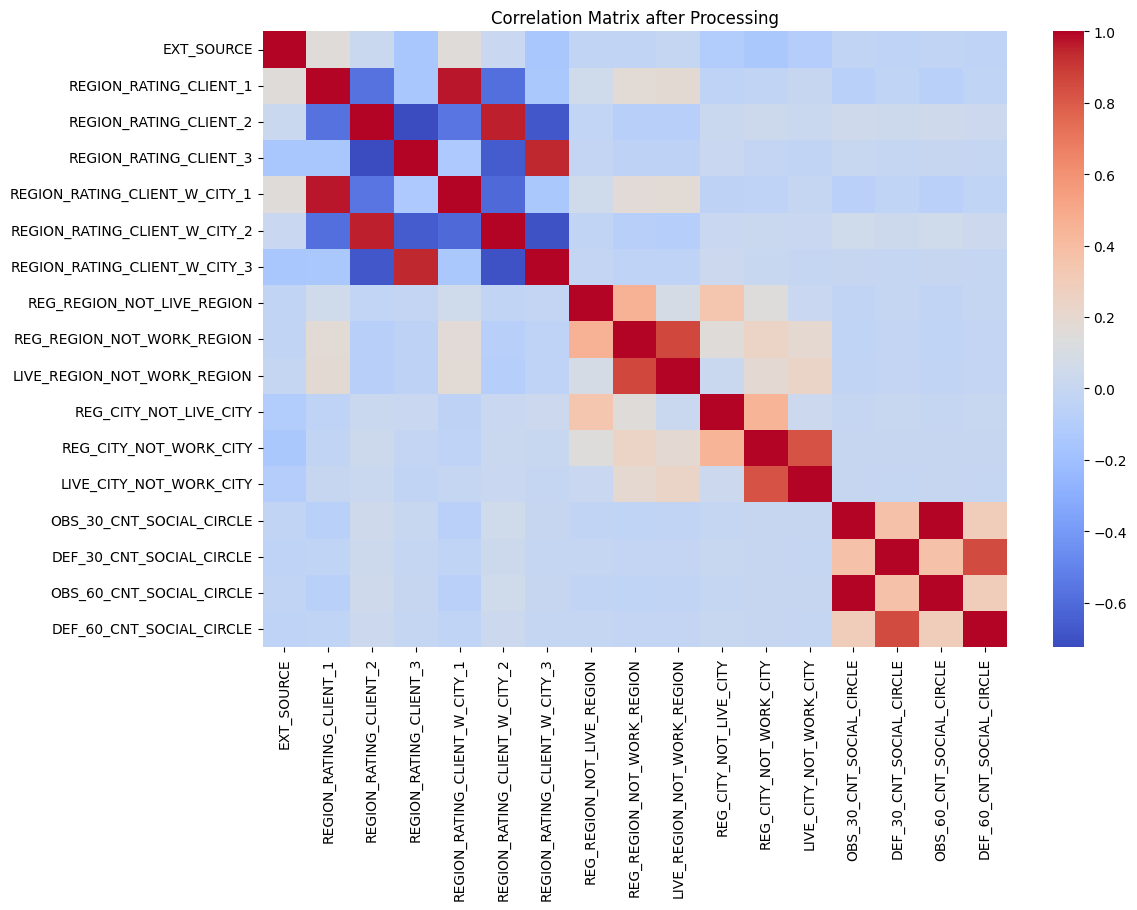

In [276]:
# Tạo df_list mới các biến đã xử lí từ df
df_list_new = df[[
    'EXT_SOURCE',
    'REGION_RATING_CLIENT_1', 'REGION_RATING_CLIENT_2', 'REGION_RATING_CLIENT_3',
    'REGION_RATING_CLIENT_W_CITY_1', 'REGION_RATING_CLIENT_W_CITY_2', 'REGION_RATING_CLIENT_W_CITY_3',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'
]].copy()

# Corrlation matrix sau khi xử lí
plt.figure(figsize=(12, 8))
corr = df_list_new.corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix after Processing")
plt.show()
